In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc
import pickle
from tqdm import tqdm

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg
import os

save = 'figures/paper_plots/'

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
def run_spritz(period=10, conc=0.6, dur=1, num=10, noise=False, osc_type=1,
              fix_c_er=False):
    '''
    Run a spritz experiment
    period: second between spritzes
    conc: concentration
    dur: duration of spritz
    num: number of sprtizes
    osc_type:
        1: exponential ramping
        2: flat pulses
    !Note that specific configurations of input_smoothing and oscillation on duration
    need to be used to get exponential_oscillation2 to work (check help details)
    '''
    
    max_step = dur * 0.1
    # print(max_step)
    t_f = (period + dur) * (num + 1)
    
    cfg.input_max = conc
    cfg.input_start = 0
    cfg.input_duration = 0
    cfg.oscillation_on_duration = dur
    cfg.oscillation_off_duration = period
    cfg.num_oscillations = num
    cfg.input_smoothing = dur/2
    
    if osc_type == 1:
        run_experiment('exponential_oscillation2', t_f=t_f, max_step=max_step, noise=noise,
                      fix_c_er=fix_c_er)
    if osc_type == 2:
        run_experiment('oscillation', t_f=t_f, max_step=max_step, noise=noise,
                      fix_c_er=fix_c_er)
    

**Goals**

* Identify factors contributing to "missed" spikes
    * Set different initial conditions and response to spikes
* Identify effects of noise
    * With the conditions dur=1, period=10, conc=3, noise=0.05, we see that in some cases, a bit of noise is enough to throw the system into a case of alternating spikes. Wonder if this effect persists

# Exploring missed spikes

Here, just going to go through different scenarios to see if we can see patterns for missed spikes

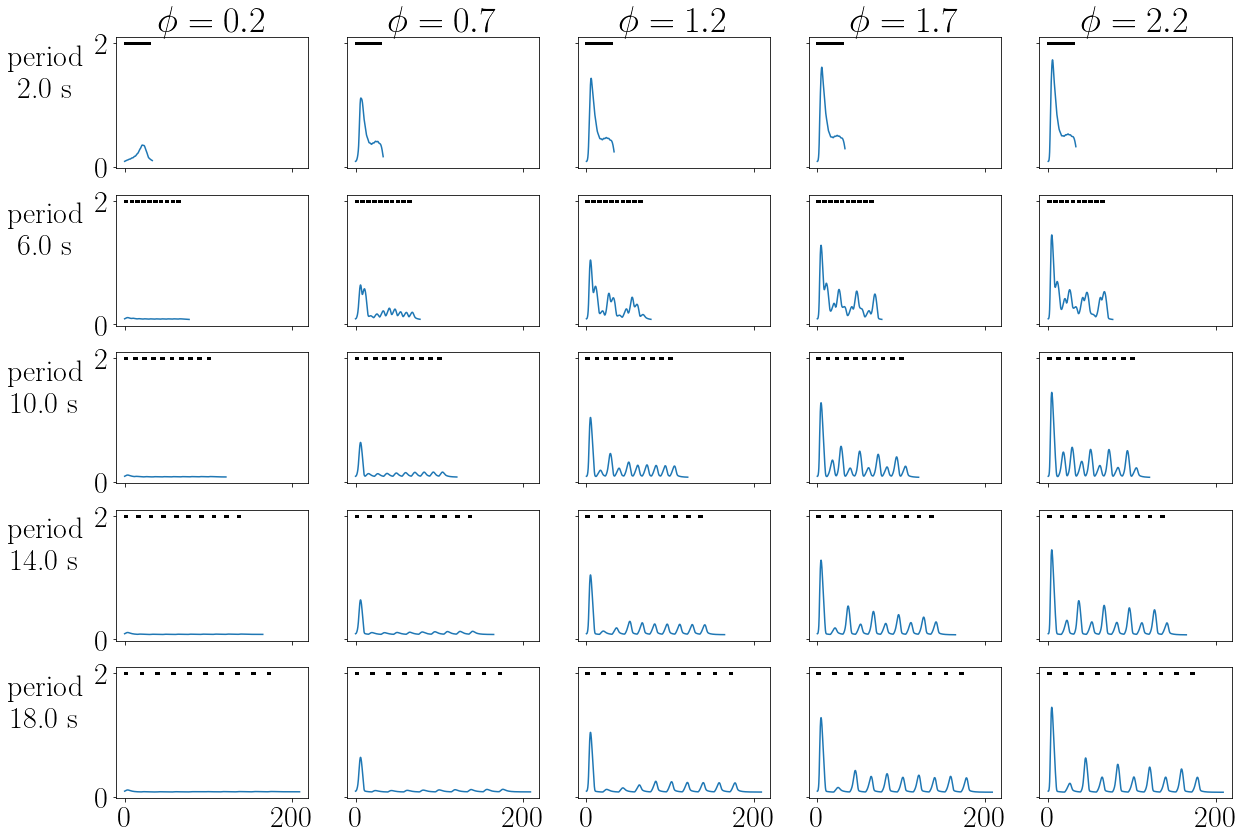

In [101]:
periods = np.arange(2, 2.1+4*5, 4)
gluts = np.arange(0.2, 0.3+0.5*5, 0.5)
fig, ax = plt.subplots(5, 5, figsize=(20, 14), sharex=True, sharey=True)
set_init('poisson')
for i in range(5):
    ax[i, 0].set_ylabel('period \n ' + str(periods[i]) + ' s', rotation=0, labelpad=50)
    ax[0, i].set_title('$\phi=' + str(round(gluts[i], 1)) + '$')
    for j in range(5):
        period = periods[i]
        glut = gluts[j]
        run_spritz(period=period, conc=glut, dur=1)
        
        ax[i, j].plot(cfg.t, cfg.c)
        spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*t for t in range(cfg.num_oscillations)])
        
        for k in range(cfg.num_oscillations):
            ax[i, j].plot([spikes[k], spikes[k] + cfg.oscillation_on_duration + 1], [2, 2], c='k', linewidth=3)

        

# Delayed spike responses

One interesting phenomenon is that the calcium spikes occur delayed from when the glutamate is spritzed. First I would like to measure how this delay is as a function of concentration. This is of course cause by the requisite build up of GPCR activation and IP3

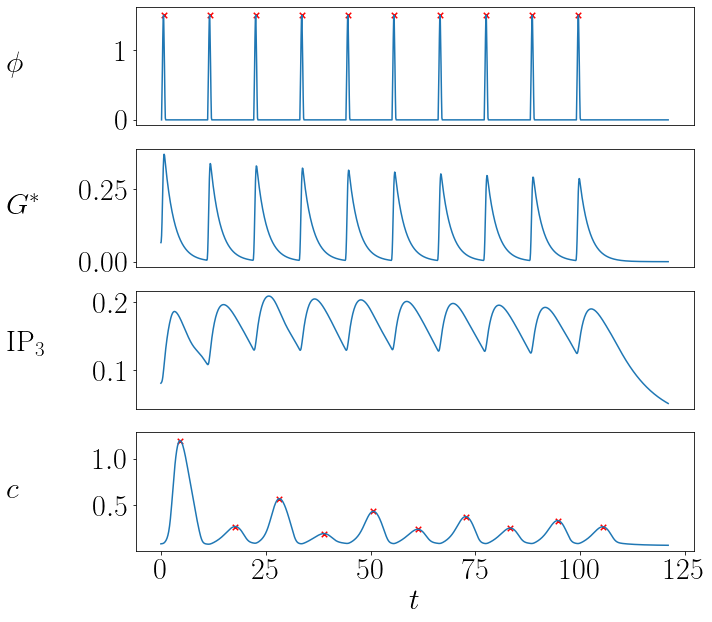

In [8]:
set_init('poisson')
run_spritz(dur=1, period=10, conc=1.5)
# plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c_er', 'h', 'p', 'c'])
ax = plot_experiment_plots(['glut', 'Gstar', 'p', 'c'], ret_ax=True)

glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
t_glut_spikes = cfg.t_input[glut_spikes]
c_spikes = scipy.signal.find_peaks(cfg.c)[0]
t_c_spikes = cfg.t[c_spikes]

ax[0].scatter(t_glut_spikes, cfg.glut[glut_spikes], marker='x', c='red', s=30)
ax[3].scatter(t_c_spikes, cfg.c[c_spikes], marker='x', c='red', s=30)


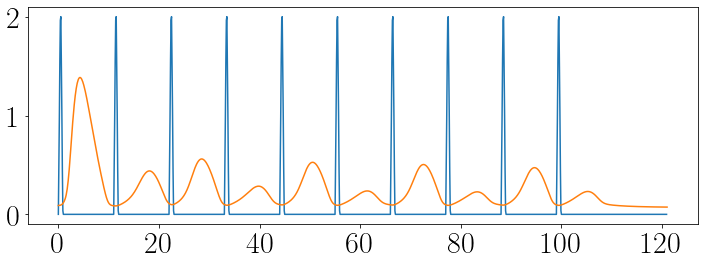

In [10]:
plt.figure(figsize=(12,4))
plt.plot(cfg.t_input, cfg.glut)
plt.plot(cfg.t, cfg.c)

It makes sense here that the first spike has less delay as we increase the concentration, but as concentration increases there is a minimal delay, 

**Measure delay as fraction of cycle**

Text(0.5, 0, 't')

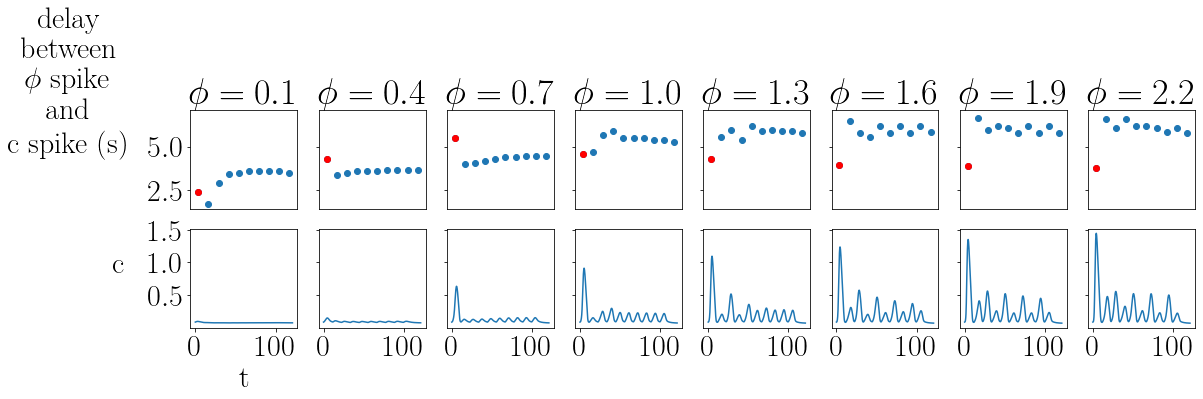

In [33]:
gluts = np.arange(0.1, 2.5, 0.3)
fig, ax = plt.subplots(2, 8, figsize=(18, 4), sharey='row', sharex='row')
for i, glut in enumerate(gluts):
    # x = i // 4
    # y = i % 4
    
    run_spritz(dur=1, period=10, conc=glut)

    glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
    t_glut_spikes = cfg.t_input[glut_spikes]
    c_spikes = scipy.signal.find_peaks(cfg.c)[0]
    t_c_spikes = cfg.t[c_spikes]

    ax[0, i].scatter(np.arange(10), t_c_spikes - t_glut_spikes)
    ax[0, i].scatter([0], t_c_spikes[0] - t_glut_spikes[0], c='red')

    ax[1, i].plot(cfg.t, cfg.c)
    ax[0, i].set_title('$\phi=' + str(round(glut, 1)) + '$')
    ax[0, i].set_xticks([])
    
ax[0, 0].set_ylabel('delay \n between \n $\phi$ spike \n and \n c spike (s)', rotation=0, labelpad=80)
# ax[0, 0].set_xlabel('spike number')
ax[1, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[1, 0].set_xlabel('t')

# plt.tight_layout()
    

Text(0.5, 0, 't')

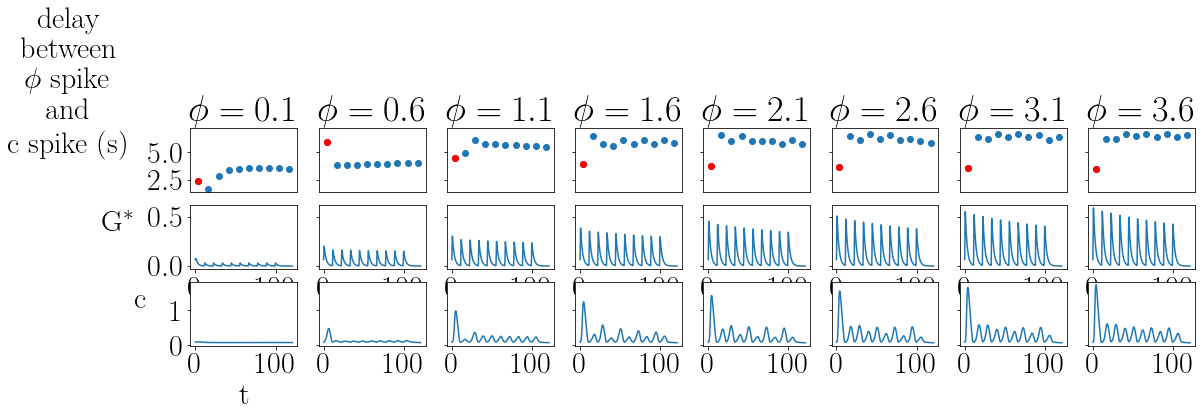

In [37]:
gluts = np.arange(0.1, 4., 0.5)
fig, ax = plt.subplots(3, 8, figsize=(18, 4), sharey='row', sharex='row')
for i, glut in enumerate(gluts):
    # x = i // 4
    # y = i % 4
    
    run_spritz(dur=1, period=10, conc=glut)

    glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
    t_glut_spikes = cfg.t_input[glut_spikes]
    c_spikes = scipy.signal.find_peaks(cfg.c)[0]
    t_c_spikes = cfg.t[c_spikes]

    ax[0, i].scatter(np.arange(10), t_c_spikes - t_glut_spikes)
    ax[0, i].scatter([0], t_c_spikes[0] - t_glut_spikes[0], c='red')

    ax[2, i].plot(cfg.t, cfg.c)
    ax[1, i].plot(cfg.t, cfg.Gstar)
    ax[0, i].set_title('$\phi=' + str(round(glut, 1)) + '$')
    ax[0, i].set_xticks([])
    
ax[0, 0].set_ylabel('delay \n between \n $\phi$ spike \n and \n c spike (s)', rotation=0, labelpad=80)
# ax[0, 0].set_xlabel('spike number')
ax[1, 0].set_ylabel('G$^*$', rotation=0, labelpad=30)
ax[2, 0].set_ylabel('c', rotation=0, labelpad=30)
ax[2, 0].set_xlabel('t')

# plt.tight_layout()
    

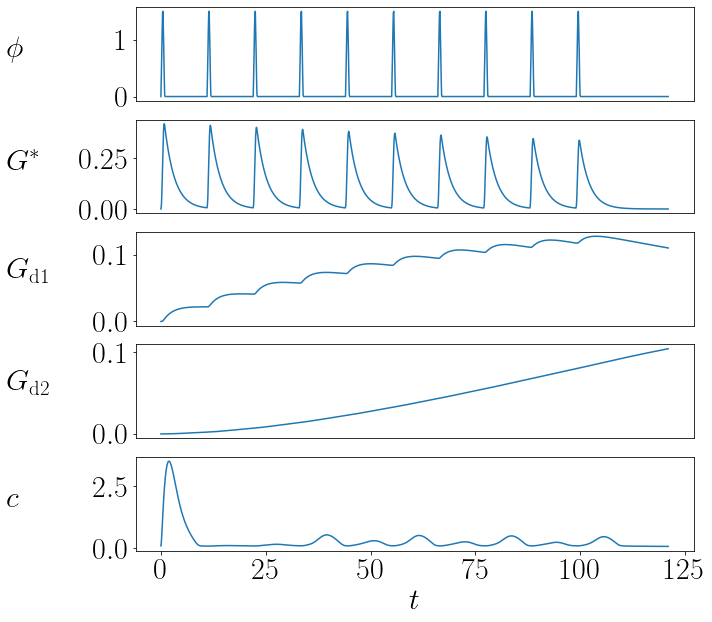

In [35]:
run_spritz(dur=1, period=10, conc=1.5)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'])

# Noise

Observe how noise effects the results, especially for those in the range much more variable in response

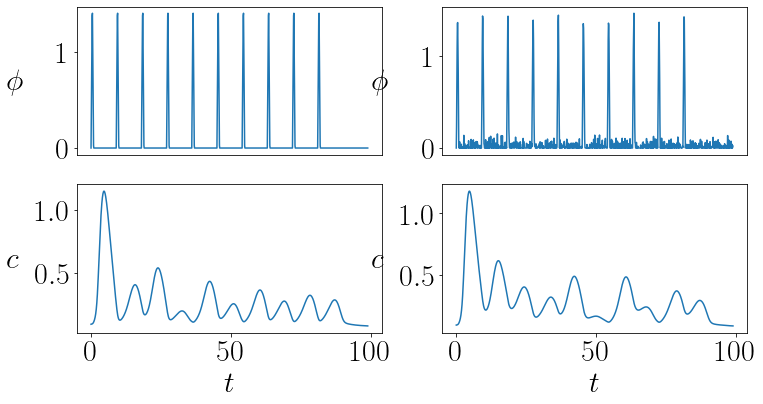

In [7]:
set_init('poisson')
conc = 1.4

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
run_spritz(dur=1, period=8, conc=conc)
plot_experiment_plots(['glut', 'c'], axs=ax[:, 0])

run_spritz(dur=1, period=8, conc=conc, noise=0.05)
# plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c_er', 'h', 'p', 'c'])
plot_experiment_plots(['glut', 'c'], axs=ax[:, 1])


## Testing if a single large spike is sufficient to throw into a cycle of missed spikes

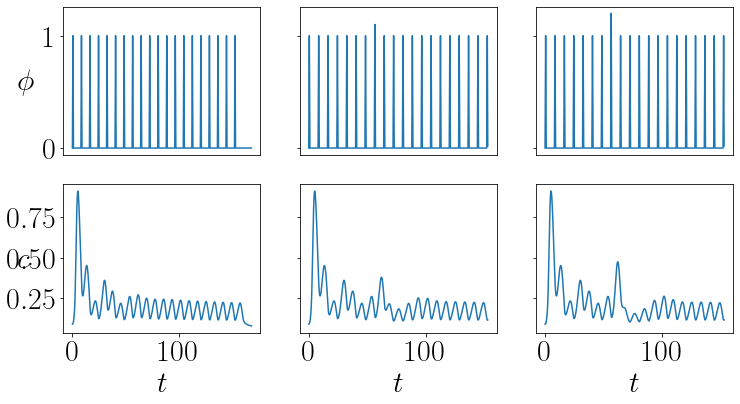

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharey='row')

run_spritz(period=7, conc=1, dur=1, num=20)
plot_experiment_plots(['glut', 'c'], axs=ax[:, 0])

run_experiment('exponential_oscillation2', t_f=9*6 + 2)
cfg.input_max = 1.1
continue_experiment('exponential_oscillation2', t_cont=5)
cfg.input_max = 1
continue_experiment('exponential_oscillation2', t_cont=9*10+2)

# plt.plot(cfg.t, cfg.c)
plot_experiment_plots(['glut', 'c'], axs=ax[:, 1], add_ylabels=False)


run_experiment('exponential_oscillation2', t_f=9*6 + 2)
cfg.input_max = 1.2
continue_experiment('exponential_oscillation2', t_cont=5)
cfg.input_max = 1
continue_experiment('exponential_oscillation2', t_cont=9*10+2)

# plt.plot(cfg.t, cfg.c)
plot_experiment_plots(['glut', 'c'], axs=ax[:, 2], add_ylabels=False)

# Missed spikes

Figuring out conditions by which we get a missed spike. Start at varying initial conditions and give a single spritz

In [34]:
'''
Run a step experiment to get a range of values to work with for initial conditions
'''
# granularities = [10, 10, 10, 10] #granularity of each range
granularities = [1, 10, 10, 10] #granularity of each range
set_init('default')
run_experiment('step', max_step=0.5)
variables = ['c', 'c_tot', 'h', 'p']
ranges = []
result_rows = []
for i, var in enumerate(variables):
    if i == 0:
        ranges.append([0.0951442])
    else:
        y = getattr(cfg, var)
        ranges.append(np.linspace(y.min(), y.max(), granularities[i]))

indices = []
mesh = np.meshgrid(*ranges)
for i in range(granularities[0]):
    for j in range(granularities[1]):
        for k in range(granularities[2]):
            # indices.append((i,j,k))
            for l in range(granularities[3]):
                indices.append((i, j, k, l))

for idx in tqdm(indices):
    result_dict = {}
    for i, var in enumerate(variables):
        cfg.all_init[i] = ranges[i][idx[i]]
        result_dict[var] = ranges[i][idx[i]]
    run_spritz(dur=1, period=10, num=2, conc=1.5)
    result_dict['max_c'] = cfg.c.max()
    result_dict['max_c_t'] = cfg.t[np.argmax(cfg.c)]
    result_dict['spike'] = cfg.c[scipy.signal.find_peaks(cfg.c)[0]]
    
    result_rows.append(result_dict)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:51<00:00,  8.98it/s]


In [36]:
df = pd.DataFrame(result_rows)

Text(0, 0.5, 'number of occurrences')

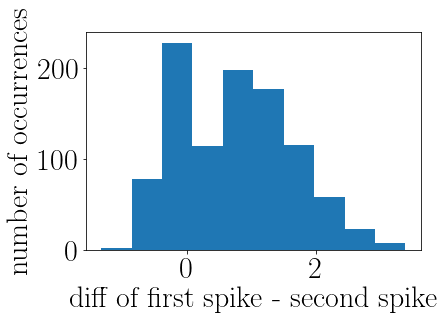

In [42]:
plt.hist([df['spike'][t][0] - df['spike'][t][1] for t in range(1000)])
# plt.xlabel('first c spike height')
plt.xlabel('diff of first spike - second spike')
plt.ylabel('number of occurrences')

In [43]:
diffs = [df['spike'][t][0] - df['spike'][t][1] for t in range(1000)]

In [44]:
df['diff'] = diffs

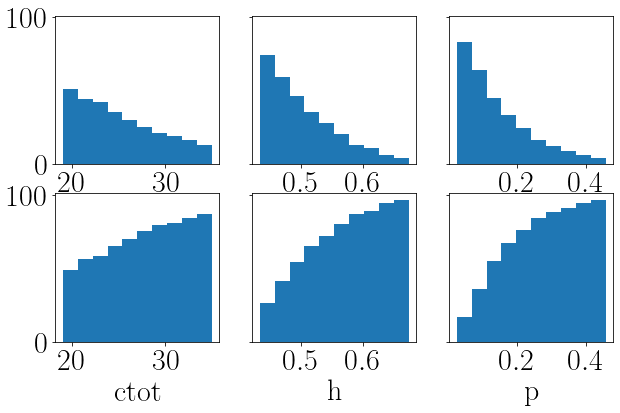

In [51]:
variables = ['c_tot', 'h', 'p']
labels = ['ctot', 'h', 'p']
fig, ax = plt.subplots(2, 3, figsize=(10,6), sharey=True)
for i, var in enumerate(variables):
    ax[0, i].hist(df[df['diff'] < 0][var])
    ax[1, i].hist(df[df['diff'] > 0][var])

    ax[1, i].set_xlabel(labels[i])

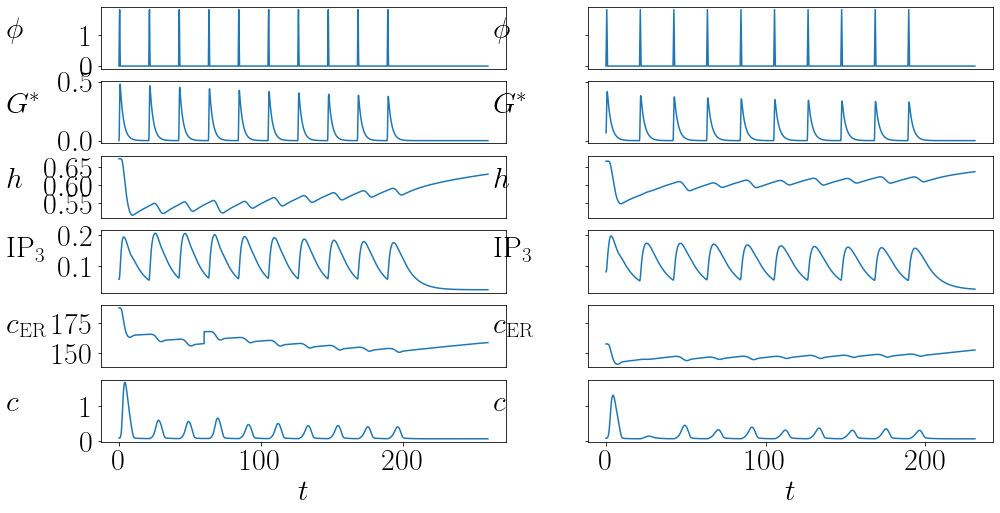

In [15]:
fig, ax = plt.subplots(6, 2, figsize=(16, 8), sharey='row')

run_spritz(period=20, conc=1.8, dur=1, noise=0.0)
# set_init('poisson')
set_init('default')
# cfg.all_init[2] -= 0.15
def kick(var='c_er', kick=10):
    '''
    perform a kick for a variable
    '''    
    if var == 'c_er':
        c_er = cfg.c_er[-1]
        c = cfg.c[-1]
        c_er = c_er + kick
        c_tot = c_er / cfg.gamma + c
        cfg.c_tot[-1] = c_tot
    else:
        y = getattr(cfg, var)
        y[-1] = y[-1] + kick
        setattr(cfg, var, y)

run_experiment('exponential_oscillation2', t_f=60, max_step=0.05)
kick(kick=10)
# cfg.c_tot[-1] += 5
continue_experiment('exponential_oscillation2', t_cont=200, max_step=0.05)
plot_experiment_plots(['glut', 'Gstar', 'h', 'p', 'c_er', 'c'], axs=ax[:, 0])

set_init('poisson')
run_spritz(period=20, conc=1.8, dur=1, noise=0.0)
plot_experiment_plots(['glut', 'Gstar', 'h', 'p', 'c_er', 'c'], axs=ax[:, 1])


# Demos

In [211]:
folder = 'figures/paper_plots/spritz/'

## Intro

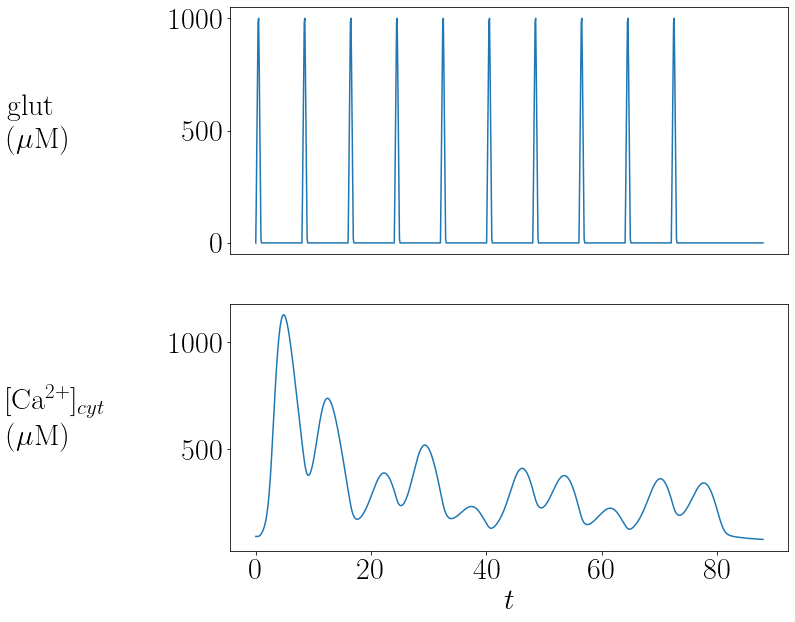

In [17]:
run_spritz(period=7, conc=1)
plot_experiment_plots(['glut', 'c'])
# plt.savefig(folder + 'intro_phenom', bbox_inches='tight')

## Various patterns

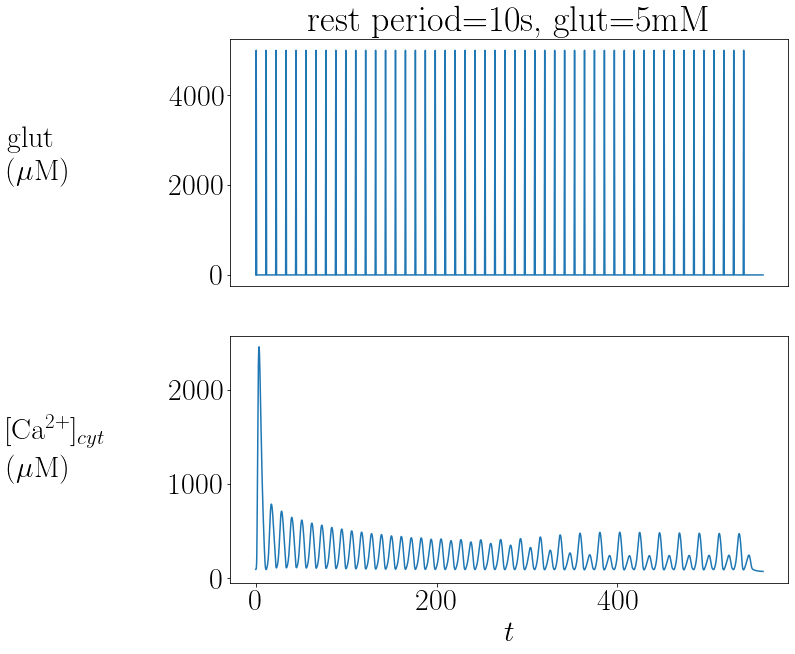

In [218]:
period = 10
glut = 5
run_spritz(period=period, conc=glut, dur=1, num=50)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'c'], ret_ax=True)
ax[0].set_title(f'rest period={period}s, glut={glut}mM')
plt.savefig(folder + '10s5m', bbox_inches='tight')

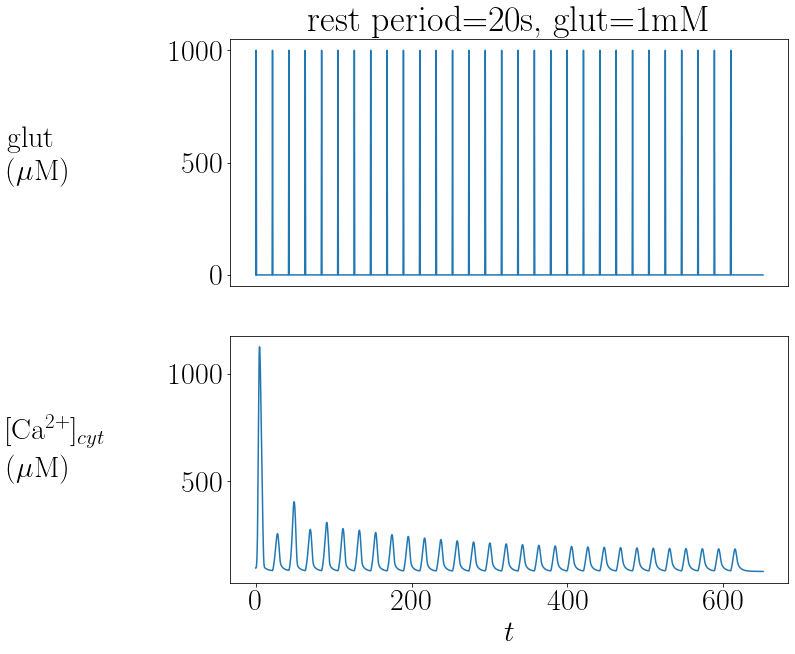

In [219]:
period = 20
glut = 1
run_spritz(period=period, conc=glut, dur=1, num=30)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'c'], ret_ax=True)
ax[0].set_title(f'rest period={period}s, glut={glut}mM')
plt.savefig(folder + '10s1m', bbox_inches='tight')

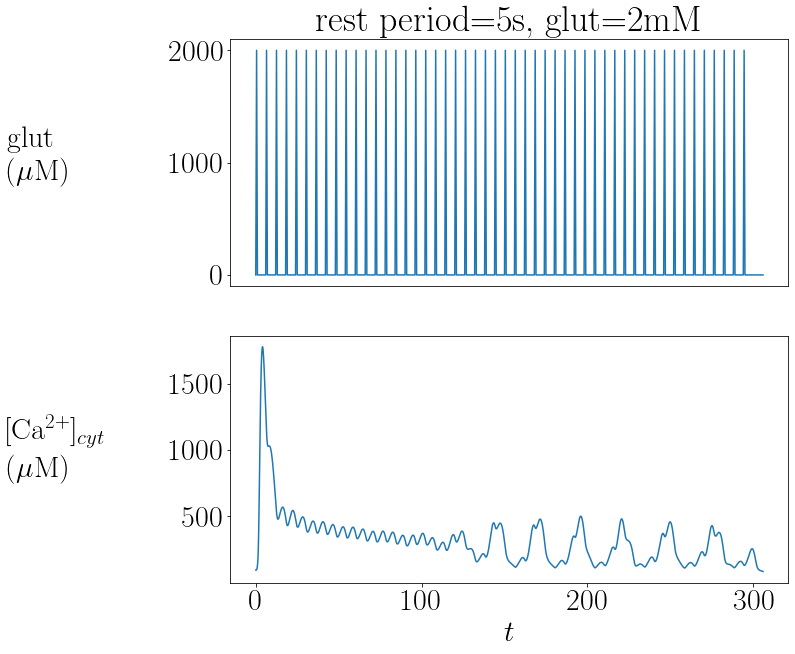

In [223]:
period = 5
glut = 2
run_spritz(period=period, conc=glut, dur=1, num=50)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'c'], ret_ax=True)
ax[0].set_title(f'rest period={period}s, glut={glut}mM')
plt.savefig(folder + f'{period}s{glut}m', bbox_inches='tight')

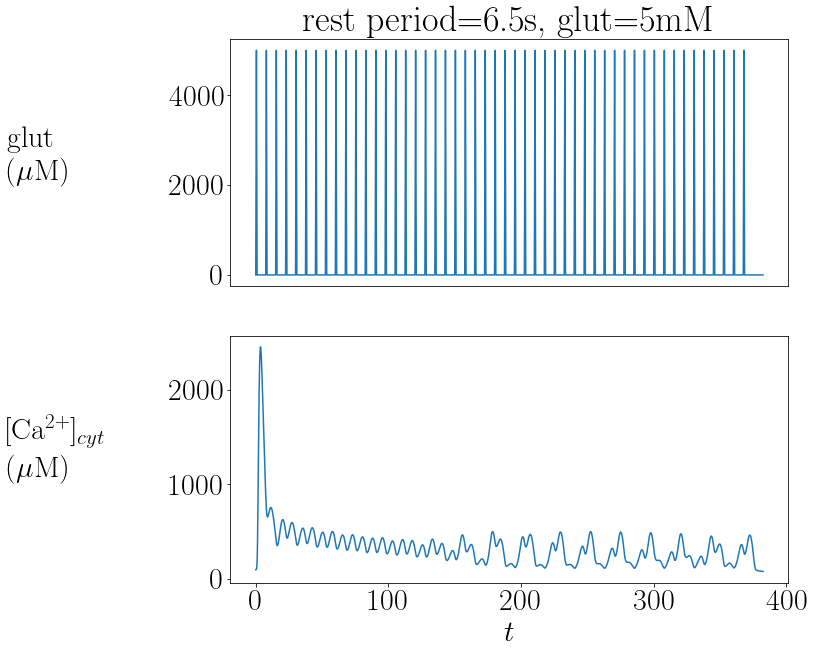

In [225]:
period = 6.5
glut = 5
run_spritz(period=period, conc=glut, dur=1, num=50)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'c'], ret_ax=True)
ax[0].set_title(f'rest period={period}s, glut={glut}mM')
plt.savefig(folder + f'{period}s{glut}m.png', bbox_inches='tight')

Text(0.5, 1.0, 'rest period=5s, glut=2mM')

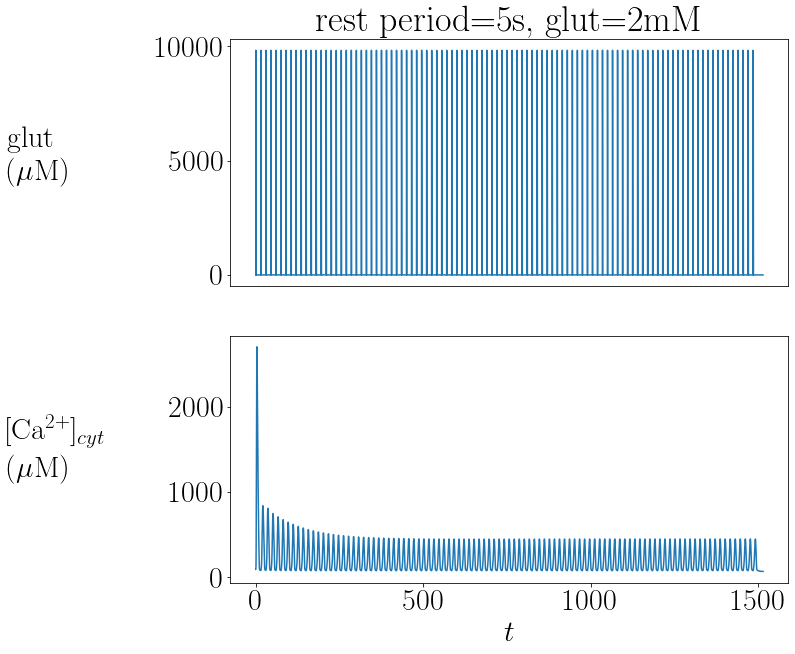

In [11]:
run_spritz(period=14, conc=10, dur=1, num=100)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'c'], ret_ax=True)
ax[0].set_title('rest period=5s, glut=2mM')

## Arnold's Tongue

In [87]:
gluts = np.linspace(1, 10, 100)
periods = np.linspace(4, 14, 100)
final_pattern_spike_count = []
final_pattern_len = []
cfg.all_init = all_init2
# run_spritz(period=7, conc=8, num=40)
# plot_experiment_plots(['glut', 'c'])

for glut in tqdm(gluts):
    for period in periods:
        run_spritz(period=period, conc=glut, dur=1, num=30)

        #Get spike amplitudes
        glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
        glut_spikes = np.append(glut_spikes, [-1])
        c_spikes = []
        c_spikes_amp = []
        for i in range(len(glut_spikes) - 1):
            idx1 = glut_spikes[i]
            idx2 = glut_spikes[i+1]
            spikes = scipy.signal.find_peaks(cfg.c[idx1:idx2])[0]
            if len(spikes) == 0:
                c_spike = np.argmax(np.diff(cfg.c[idx1:idx2]) / np.diff(cfg.t[idx1:idx2])) + idx1
            else:
                c_spike = spikes[0] + idx1
            c_spikes.append(c_spike)
            c_spikes_amp.append(cfg.c[c_spike])
        c_spikes = np.array(c_spikes)
        c_spikes_amp = np.array(c_spikes_amp)
        glut_spikes = glut_spikes[:-1]

        #Find what distinct amplitudes are reached
        rnge = 50
        cs = c_spikes_amp[20:]
        bin_idxs = []
        c_amp_bins = np.full(10, np.nan)
        cur_idx = 0
        for i, c in enumerate(cs):
            if i == 0:
                c_amp_bins[cur_idx] = c
                cur_idx += 1
            else:
                if not np.any(np.abs(c_amp_bins - c) < rnge):
                    c_amp_bins[cur_idx] = c
                    cur_idx += 1


        #Find what pattern is
        for i, c in enumerate(cs):
            bin_idxs.append(np.argmax(np.abs(c_amp_bins - c) < 10))

        found_pattern = False
        bin_idxs = bin_idxs[:-2]
        pattern_lens = np.arange(1, int(len(bin_idxs) / 2))
        for lens in pattern_lens:
            pattern = bin_idxs[:lens]
            # print(pattern)
            success = True
            for i in range(len(bin_idxs)):
                rep_idx = i % len(pattern)
                if bin_idxs[i] != pattern[rep_idx]:
                    # print('fail')
                    success = False
                    break
            if success:
                # print(pattern)
                found_pattern = True
                break


        #Count how many spikes per
        if found_pattern:
            spike_idx = np.argmax(c_amp_bins[c_amp_bins > 0])
            pattern_spike_count = np.sum(np.array(pattern) == spike_idx)
            pattern_len = len(pattern)
        else:
            pattern_spike_count = 0
            pattern_len = 0
        final_pattern_spike_count.append(pattern_spike_count)
        final_pattern_len.append(pattern_len)
        pickle.dump([cfg.t, cfg.c, glut, period], open('data/spritz/' + str(glut) + '_' + str(period), 'wb'))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [3:22:03<00:00, 121.23s/it]


In [171]:
gluts = np.linspace(1, 10, 100)
periods = np.linspace(4, 14, 100)
final_pattern_spike_count = []
final_pattern_len = []

for glut in tqdm(gluts):
    for period in periods:
        cfg.input_max = glut
        cfg.t, cfg.c, glut, period = pickle.load(open(f'data/spritz/{str(glut)}_{str(period)}', 'rb'))

        dur = 1
        num = 30
        conc = glut

        #Get spike amplitudes
        start = 5
        period2 = (period + 1) * 10
        glut_spikes = np.arange(start, period2*num+start, period2, dtype=int)
        glut_spikes = np.append(glut_spikes, [-1])

        c_spikes = []
        c_spikes_amp = []
        for i in range(len(glut_spikes) - 1):
            idx1 = glut_spikes[i]
            idx2 = glut_spikes[i+1]
            spikes = scipy.signal.find_peaks(cfg.c[idx1:idx2])[0]
            if len(spikes) == 0:
                c_spike = np.argmax(np.diff(cfg.c[idx1:idx2]) / np.diff(cfg.t[idx1:idx2])) + idx1
            else:
                c_spike = spikes[0] + idx1
            c_spikes.append(c_spike)
            c_spikes_amp.append(cfg.c[c_spike])
        c_spikes = np.array(c_spikes)
        c_spikes_amp = np.array(c_spikes_amp)
        glut_spikes = glut_spikes[:-1]

        #Find what distinct amplitudes are reached
        rnge = 20
        cs = c_spikes_amp[10:]
        bin_idxs = []
        c_amp_bins = np.full(20, np.nan)
        cur_idx = 0
        for i, c in enumerate(cs):
            # print(c)
            # print(c_amp_bins)
            if i == 0:
                idx = cur_idx
                cur_idx += 1
            else:
                if np.any(np.abs(c_amp_bins - c) < rnge):
                    idx = np.argmin(np.abs(c_amp_bins[c_amp_bins > 0] - c))
                else:
                    idx = cur_idx
                    cur_idx += 1
            c_amp_bins[idx] = c
            bin_idxs.append(idx)


        #Find what pattern is
        # for i, c in enumerate(cs):
        #     bin_idxs.append(np.argmax(np.abs(c_amp_bins - c) < 10))

        found_pattern = False
        bin_idxs = bin_idxs[:-2]
        pattern_lens = np.arange(1, int(len(bin_idxs) / 2))
        for lens in pattern_lens:
            pattern = bin_idxs[:lens]
            # print(pattern)
            success = True
            for i in range(len(bin_idxs)):
                rep_idx = i % len(pattern)
                if bin_idxs[i] != pattern[rep_idx]:
                    # print('fail')
                    success = False
                    break
            if success:
                # print(pattern)
                found_pattern = True
                break
        # print(bin_idxs)

        #Count how many spikes per
        if found_pattern:
            spike_idx = np.argmax(c_amp_bins[c_amp_bins > 0])
            pattern_spike_count = np.sum(np.array(pattern) == spike_idx)
            pattern_len = len(pattern)
        else:
            pattern_spike_count = 0
            pattern_len = 0
        final_pattern_spike_count.append(pattern_spike_count)
        final_pattern_len.append(pattern_len)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


352.5621440137189
[nan nan nan nan nan nan nan nan nan nan]
539.8198311563001
[352.56214401          nan          nan          nan          nan
          nan          nan          nan          nan          nan]
360.0804399063149
[352.56214401 539.81983116          nan          nan          nan
          nan          nan          nan          nan          nan]
533.61073025322
[360.08043991 539.81983116          nan          nan          nan
          nan          nan          nan          nan          nan]
366.1136832735186
[360.08043991 533.61073025          nan          nan          nan
          nan          nan          nan          nan          nan]
528.5951449010082
[366.11368327 533.61073025          nan          nan          nan
          nan          nan          nan          nan          nan]
371.1084012955089
[366.11368327 528.5951449           nan          nan          nan
          nan          nan          nan          nan          nan]
524.4095159990686
[371.1084013 528.5

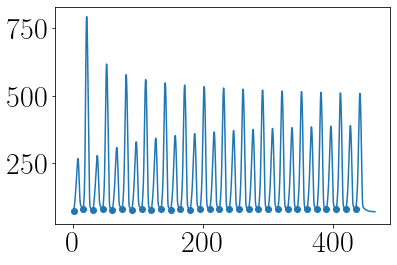

In [165]:
cfg.input_max = glut
glut = gluts[-1]
period = periods[-1]
cfg.t, cfg.c, glut, period = pickle.load(open(f'data/spritz/{str(glut)}_{str(period)}', 'rb'))

dur = 1
num = 30
conc = glut

cfg.input_max = conc
cfg.input_start = 0
cfg.input_duration = 0
cfg.oscillation_on_duration = dur
cfg.oscillation_off_duration = period
cfg.num_oscillations = num
cfg.input_smoothing = dur/2
max_step = 0.1



#Get spike amplitudes
# glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
start = 5
period2 = (period + 1) * 10
glut_spikes = np.arange(start, period2*num+start, period2, dtype=int)
glut_spikes = np.append(glut_spikes, [-1])

c_spikes = []
c_spikes_amp = []
for i in range(len(glut_spikes) - 1):
    idx1 = glut_spikes[i]
    idx2 = glut_spikes[i+1]
    spikes = scipy.signal.find_peaks(cfg.c[idx1:idx2])[0]
    if len(spikes) == 0:
        c_spike = np.argmax(np.diff(cfg.c[idx1:idx2]) / np.diff(cfg.t[idx1:idx2])) + idx1
    else:
        c_spike = spikes[0] + idx1
    c_spikes.append(c_spike)
    c_spikes_amp.append(cfg.c[c_spike])
c_spikes = np.array(c_spikes)
c_spikes_amp = np.array(c_spikes_amp)
glut_spikes = glut_spikes[:-1]

#Find what distinct amplitudes are reached
rnge = 20
cs = c_spikes_amp[10:]
bin_idxs = []
c_amp_bins = np.full(10, np.nan)
cur_idx = 0
for i, c in enumerate(cs):
    print(c)
    print(c_amp_bins)
    if i == 0:
        idx = cur_idx
        cur_idx += 1
    else:
        if np.any(np.abs(c_amp_bins - c) < rnge):
            idx = np.argmin(np.abs(c_amp_bins[c_amp_bins > 0] - c))
        else:
            idx = cur_idx
            cur_idx += 1
    c_amp_bins[idx] = c
    bin_idxs.append(idx)


#Find what pattern is
# for i, c in enumerate(cs):
#     bin_idxs.append(np.argmax(np.abs(c_amp_bins - c) < 10))

found_pattern = False
bin_idxs = bin_idxs[:-2]
pattern_lens = np.arange(1, int(len(bin_idxs) / 2))
for lens in pattern_lens:
    pattern = bin_idxs[:lens]
    # print(pattern)
    success = True
    for i in range(len(bin_idxs)):
        rep_idx = i % len(pattern)
        if bin_idxs[i] != pattern[rep_idx]:
            # print('fail')
            success = False
            break
    if success:
        # print(pattern)
        found_pattern = True
        break
print(bin_idxs)

#Count how many spikes per
if found_pattern:
    spike_idx = np.argmax(c_amp_bins[c_amp_bins > 0])
    pattern_spike_count = np.sum(np.array(pattern) == spike_idx)
    pattern_len = len(pattern)
else:
    pattern_spike_count = 0
    pattern_len = 0
final_pattern_spike_count.append(pattern_spike_count)
final_pattern_len.append(pattern_len)


plt.plot(cfg.t, cfg.c)
plt.scatter(cfg.t[glut_spikes], cfg.c[glut_spikes])

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


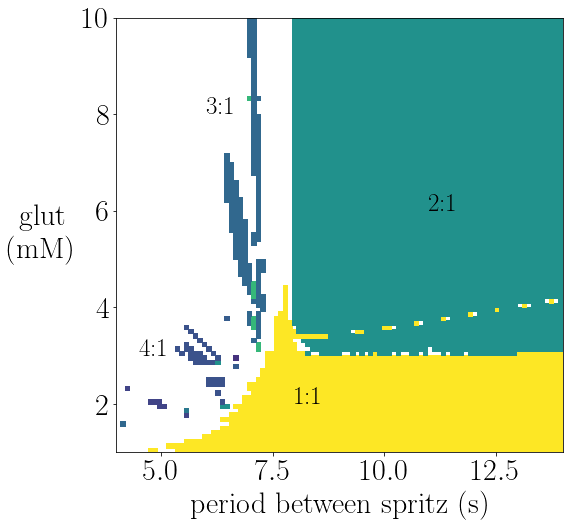

In [204]:
plt.figure(figsize=(8,8))

x, y = np.meshgrid(periods, gluts)
final_ratio = np.array(final_pattern_spike_count) / np.array(final_pattern_len)
final_ratio = final_ratio.reshape(len(periods), len(gluts))
plt.pcolor(x, y, final_ratio, vmin=0, vmax=1)
plt.xlabel('period between spritz (s)')
plt.ylabel('glut \n (mM)', rotation=0, va='center', labelpad=40)
# plt.colorbar()

plt.text(8, 2, '1:1', size=25)
plt.text(11, 6, '2:1', size=25)
plt.text(6, 8, '3:1', size=25)
plt.text(4.5, 3, '4:1', size=25)
plt.savefig('figures/paper_plots/spritz/arnold_default', bbox_inches='tight')

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


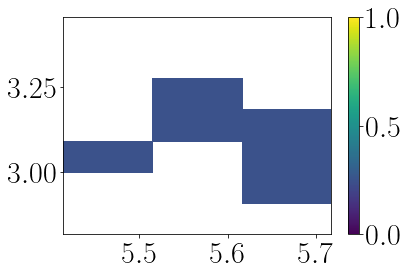

In [197]:
x_idxs = [14, 18]
y_idxs = [20, 28]
x, y = np.meshgrid(periods, gluts)
final_ratio = np.array(final_pattern_spike_count) / np.array(final_pattern_len)
final_ratio = final_ratio.reshape(len(periods), len(gluts))
plt.pcolor(x[y_idxs[0]:y_idxs[1], x_idxs[0]:x_idxs[1]], 
             y[y_idxs[0]:y_idxs[1], x_idxs[0]:x_idxs[1]], 
               final_ratio[y_idxs[0]:y_idxs[1], x_idxs[0]:x_idxs[1]], vmin=0, vmax=1)
plt.colorbar()

In [79]:
#Get spike amplitudes
glut_spikes = scipy.signal.find_peaks(cfg.glut)[0]
glut_spikes = np.append(glut_spikes, [-1])
c_spikes = []
c_spikes_amp = []
for i in range(len(glut_spikes) - 1):
    idx1 = glut_spikes[i]
    idx2 = glut_spikes[i+1]
    spikes = scipy.signal.find_peaks(cfg.c[idx1:idx2])[0]
    if len(spikes) == 0:
        c_spike = np.argmax(np.diff(cfg.c[idx1:idx2]) / np.diff(cfg.t[idx1:idx2])) + idx1
    else:
        c_spike = spikes[0] + idx1
    c_spikes.append(c_spike)
    c_spikes_amp.append(cfg.c[c_spike])
c_spikes = np.array(c_spikes)
c_spikes_amp = np.array(c_spikes_amp)
glut_spikes = glut_spikes[:-1]

#Find what distinct amplitudes are reached
rnge = 50
cs = c_spikes_amp[20:]
bin_idxs = []
c_amp_bins = np.full(10, np.nan)
cur_idx = 0
for i, c in enumerate(cs):
    if i == 0:
        c_amp_bins[cur_idx] = c
        cur_idx += 1
    else:
        if not np.any(np.abs(c_amp_bins - c) < rnge):
            c_amp_bins[cur_idx] = c
            cur_idx += 1


#Find what pattern is
for i, c in enumerate(cs):
    bin_idxs.append(np.argmax(np.abs(c_amp_bins - c) < 10))

found_pattern = False
bin_idxs = bin_idxs[:-1]
pattern_lens = np.arange(1, int(len(bin_idxs) / 2))
for lens in pattern_lens:
    pattern = bin_idxs[:lens]
    # print(pattern)
    success = True
    for i in range(len(bin_idxs)):
        rep_idx = i % len(pattern)
        if bin_idxs[i] != pattern[rep_idx]:
            # print('fail')
            success = False
            break
    if success:
        # print(pattern)
        found_pattern = True
        break


#Count how many spikes per
if found_pattern:
    spike_idx = np.argmax(c_amp_bins[c_amp_bins > 0])
    pattern_spike_count = np.sum(np.array(pattern) == spike_idx)
    pattern_len = len(pattern)
else:
    pattern_spike_count = 0
    pattern_len = 0
final_pattern_spike_count.append(pattern_spike_count)
final_pattern_len.append(pattern_len)


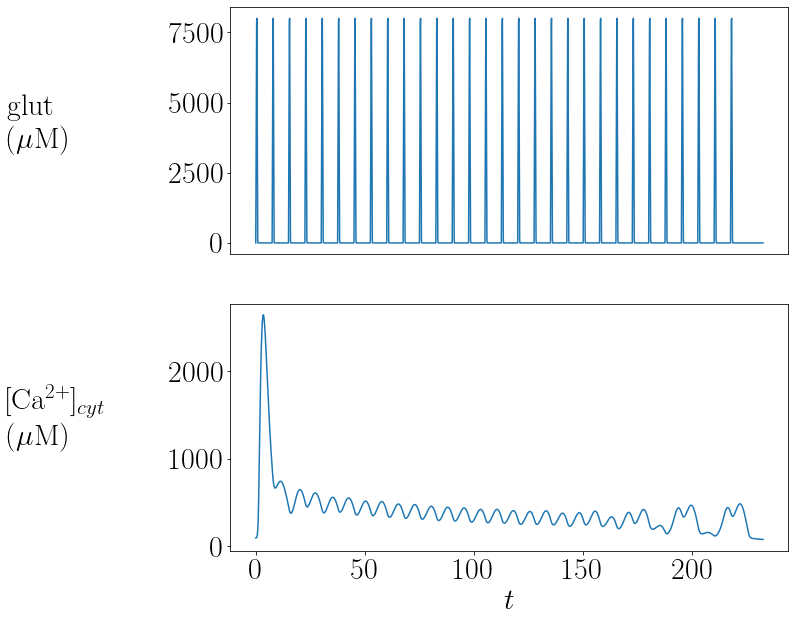

In [13]:
cfg.all_init = all_init2
run_spritz(period=6.5, conc=8, num=30)
plot_experiment_plots(['glut', 'c'])

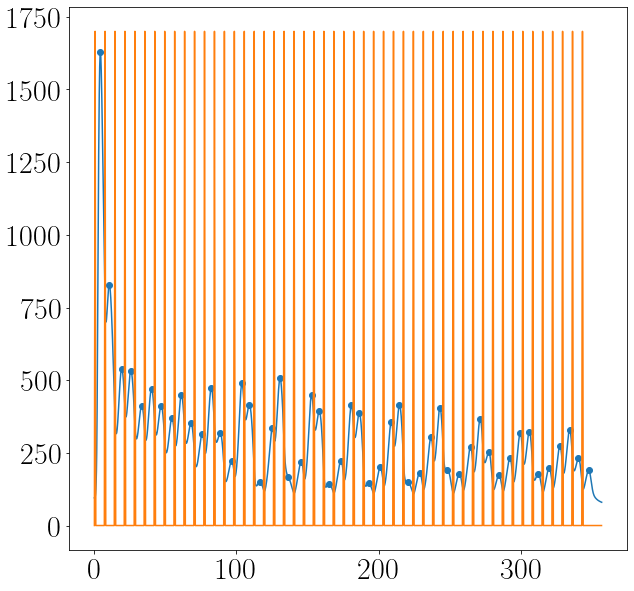

In [78]:
plt.figure(figsize=(10, 10))
plt.plot(cfg.t, cfg.c)
plt.plot(cfg.t_input, cfg.glut)
plt.scatter(cfg.t[c_spikes], cfg.c[c_spikes])

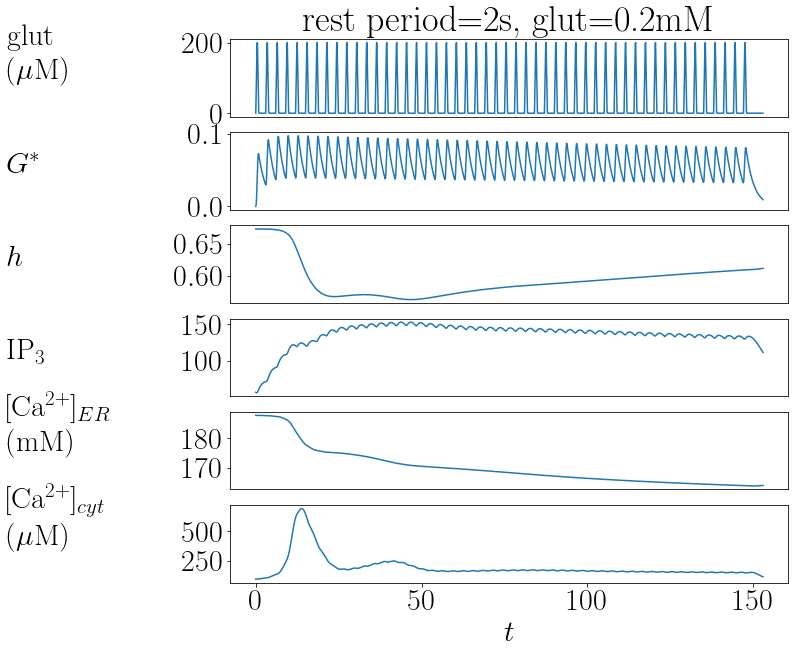

In [26]:
period = 2
glut = 0.2
cfg.v_3k = 0.1
run_spritz(period=period, conc=glut, dur=1, num=50)
# run_spritz(period=10, conc=2.5, dur=1, num=50)

ax = plot_experiment_plots(['glut', 'Gstar', 'h', 'p', 'c_er', 'c'], ret_ax=True)
ax[0].set_title(f'rest period={period}s, glut={glut}mM')
# plt.savefig(folder + f'{period}s{glut}m.png', bbox_inches='tight')

cfg.v_3k = 0.1

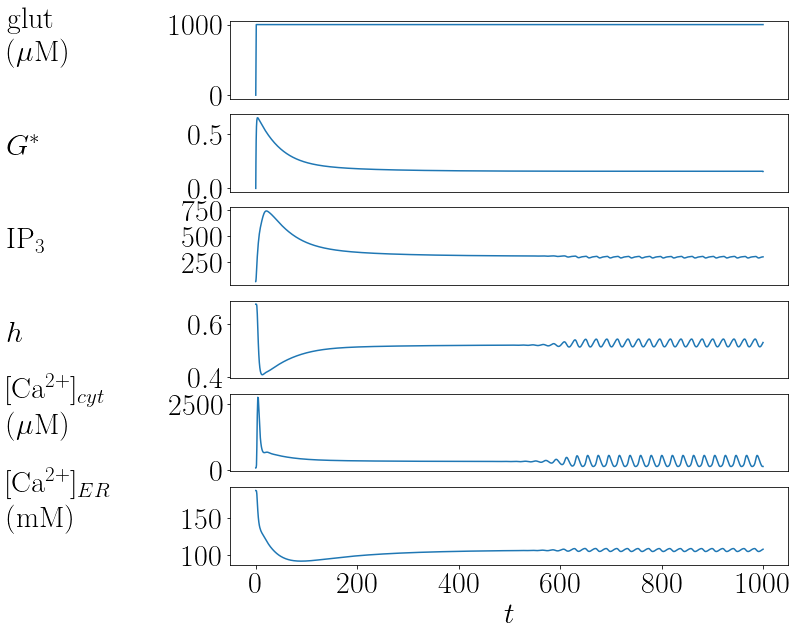

In [22]:
types = ['pulse', 'pulse', 'oscillation', 'curve', 'step']

cfg.input_max = 1
cfg.input_duration = 1000
run_experiment('pulse', max_step=1)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c', 'c_er'])


# Construct 2D Response Graph!

First, look to see if there is a concentration at which the system exibits multiple types of behaviors for different periods. We settle on 1.3

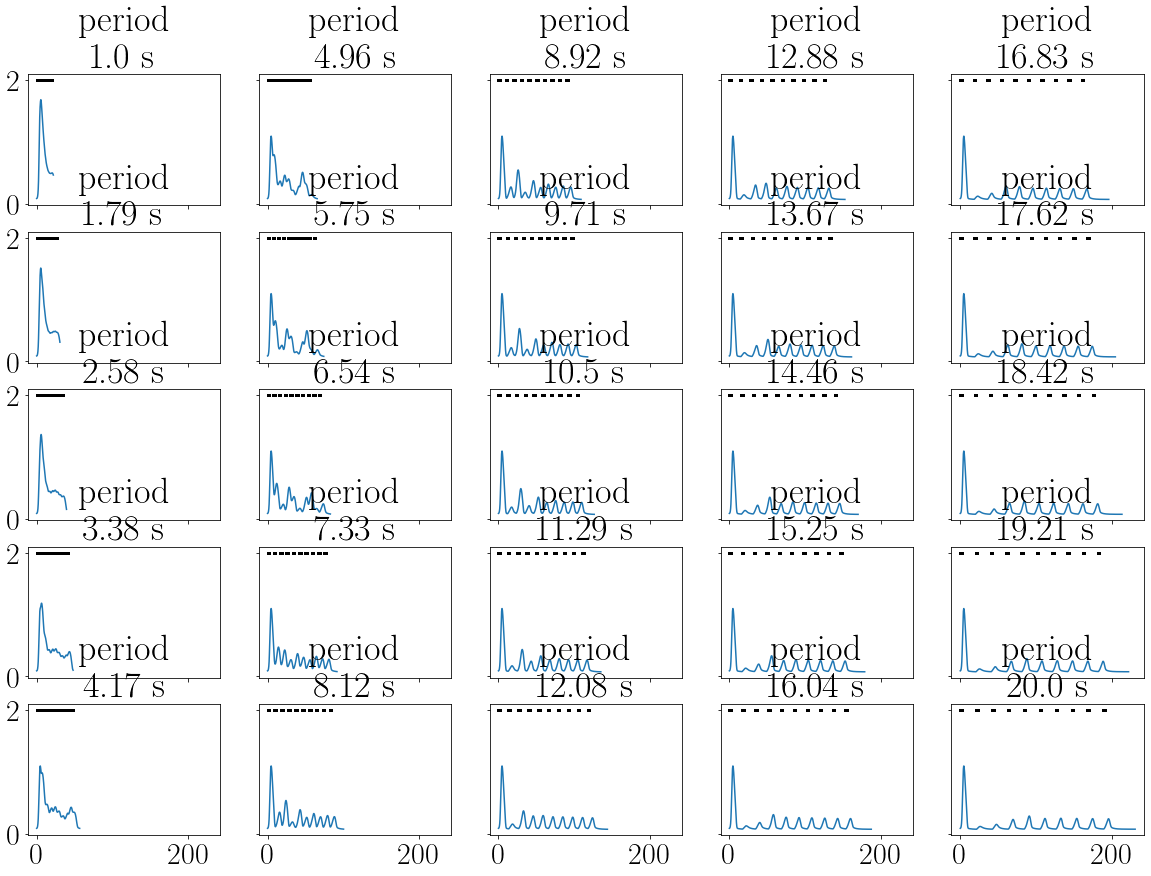

In [28]:
periods = np.linspace(1, 20, 25)
fig, ax = plt.subplots(5, 5, figsize=(20, 14), sharex=True, sharey=True)
set_init('poisson')
glut = 1.3
for i, period in enumerate(periods):
    x = i % 5
    y = i // 5
    ax[x, y].set_title('period \n ' + str(round(periods[i], 2)) + ' s')
    run_spritz(period=period, conc=glut, dur=1)

    ax[x, y].plot(cfg.t, cfg.c)
    spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*t for t in range(cfg.num_oscillations)])

    for k in range(cfg.num_oscillations):
        ax[x, y].plot([spikes[k], spikes[k] + cfg.oscillation_on_duration + 1], [2, 2], c='k', linewidth=3)

        

## Test to see importance of different starting conditions on response to spritz

1. We take a long bath to get a range of variable values that the system undergoes (min and max of each variable during the long bath)
2. From these ranges, generate 1000 conditions selected with uniform random distribution with respect to each of the variables
    1. For each initial condition we perform a 1s duration, 1.3 concentration spritz
    2. Record the maximum cytocolic calcium reached. Also record the values of the other variables after 7.5s (roughly when Gstar dies down)
3. Generate a gradient boosted tree regressor model to model max calcium with respect to the 8 variables
4. We determine that all GPCR values have little impact on response, so ignore those
5. We determine that even though current cytosolic calcium level has an effect, it quickly returns back to low levels (effectively it is a fast response). We can see from the histograms that the range of calcium levels tested is not indicative of realistic levels that would occur during periodic spritz experiments
6. Similarly, ER Calcium tends to reach a balance as seen by the histogram. So we limit these initial conditions of c_tot to between 20 and 25
7. Record another 1000 spritzes and fit a new gradient boosted tree regressor using only the remaining variables h and p
    1. This model has an R^2 score of 0.966, showing we can effectively predict response results from h and p
8. Also fit regressors to h and p values after 7.5s, given initial h and p
    2. These have less good R^2 scores, but the shape is roughly correct. Unfortunately this means that after a few spritzes we might fall off accurate predictions, but for now this should work

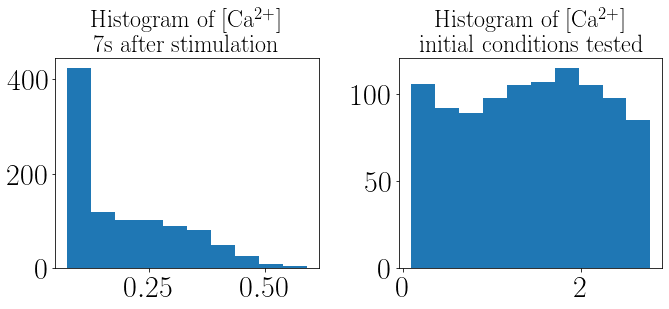

In [52]:


fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(next_vals[:, 0])
ax[0].set_title('Histogram of [Ca$^{2+}$] \n 7s after stimulation', fontsize=24)
ax[1].hist(inits[:, 0])
ax[1].set_title('Histogram of [Ca$^{2+}$] \n initial conditions tested', fontsize=24)

fig.tight_layout()

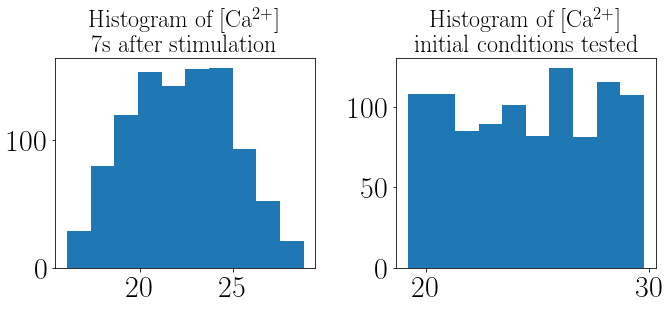

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(next_vals[:, 1])
ax[0].set_title('Histogram of [Ca$^{2+}$] \n 7s after stimulation', fontsize=24)
ax[1].hist(inits[:, 1])
ax[1].set_title('Histogram of [Ca$^{2+}$] \n initial conditions tested', fontsize=24)

fig.tight_layout()

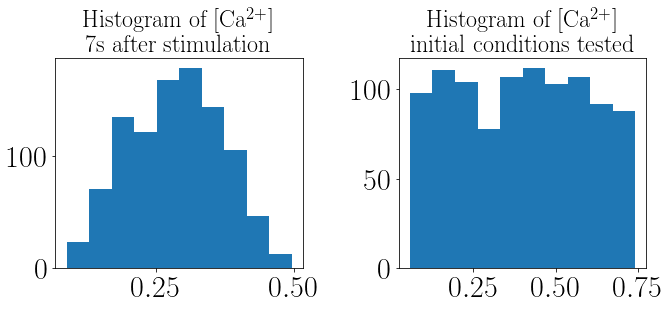

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(next_vals[:, 3])
ax[0].set_title('Histogram of [Ca$^{2+}$] \n 7s after stimulation', fontsize=24)
ax[1].hist(inits[:, 3])
ax[1].set_title('Histogram of [Ca$^{2+}$] \n initial conditions tested', fontsize=24)

fig.tight_layout()

In [1]:
from spritz_diagram import *
import xgboost as xgb
from sklearn.metrics import r2_score

var_ranges = get_condition_bounds()

#Modify calcium initial conditions to only include
#those with reasonable recovered levels during spritz (max of 0.6)
#and with a roughly equilibriated c_er level (c_tot between 20 and 25)
var_ranges[0] = (var_ranges[0][0], 0.4)
# var_ranges[1] = (20, 25)
var_ranges[2] = (var_ranges[2][0], 0.3)
num_trials = 2500
inits = np.zeros((num_trials, 8))
next_vals = np.zeros((num_trials, 8))
max_cs = np.zeros(num_trials)

for i in tqdm(range(num_trials)):
    init = get_random_init(var_ranges)
    inits[i] = init
    
    max_c, next_val = test_single_spritz(init)
    next_vals[i] = next_val
    max_cs[i] = max_c
    
#Fit full model to determine variables importances to regression
model = xgb.XGBRegressor(max_depth=2)
model.fit(inits, max_cs)
y_pred = model.predict(inits)
print('Relative importances of each variable to regressor fit')
print(model.feature_importances_)

#Fit model to only h and p variables to find R^2
# model = xgb.XGBRegressor(max_depth=2)
# model.fit(inits[:, 2:4], max_cs)
# y_pred = model.predict(inits[:, 2:4])
# r2 = r2_score(y_pred, max_cs)
# print(f'R^2 score of model fit to just h and p variables: {r2}')

C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:243: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.25it/s]


Relative importances of each variable to regressor fit
[0.33274433 0.21164617 0.18627284 0.1984871  0.02832471 0.01636555
 0.0144558  0.01170344]


In [2]:
from sklearn.decomposition import PCA



Text(0, 0.5, 'actual max c')

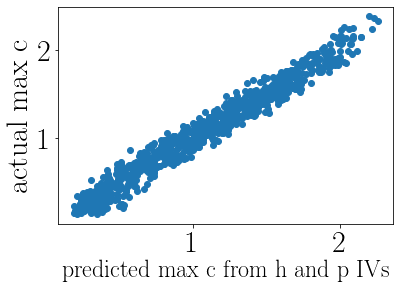

In [77]:
plt.scatter(y_pred, max_cs)
plt.xlabel('predicted max c from h and p IVs', fontsize=24)
plt.ylabel('actual max c')

In [82]:
#Fit models predicting h and p after 7.5s from h and p initial values

h_nexts = next_vals[:, 2]
p_nexts = next_vals[:, 3]

h_model = xgb.XGBRegressor(max_depth=2)
h_model.fit(inits[:, 2:4], h_nexts)
h_preds = h_model.predict(inits[:, 2:4])
h_r2 = r2_score(h_preds, h_nexts)
print(f'R^2 score for predicting h given h and p: {h_r2}')

p_model = xgb.XGBRegressor(max_depth=2)
p_model.fit(inits[:, 2:4], p_nexts)
p_preds = p_model.predict(inits[:, 2:4])
p_r2 = r2_score(p_preds, p_nexts)
print(f'R^2 score for predicting h given h and p: {p_r2}')


R^2 score for predicting h given h and p: 0.7175929985274223
R^2 score for predicting h given h and p: 0.826417585957004


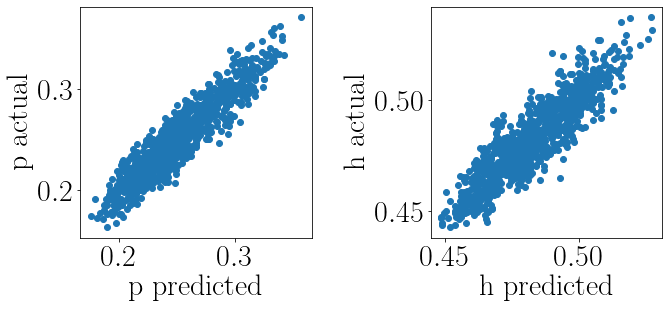

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(p_preds, p_nexts)
ax[0].set_xlabel('p predicted')
ax[0].set_ylabel('p actual')

ax[1].scatter(h_preds, h_nexts)
ax[1].set_xlabel('h predicted')
ax[1].set_ylabel('h actual')

fig.tight_layout()

### Generate h and p response 2D diagram

### Plotting by h and p

In [34]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([2.44711197e-01, 28, 4.82123581e-01, 2.51173827e-01,
       1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03]) #manually fix c_tot

var_ranges = get_condition_bounds()
print(var_ranges)
for i in range(8):
    if i not in [2, 3]:
        var_ranges[i] = (avg_nexts[i], avg_nexts[i])

num_trials = 50 * 50
hs = np.linspace(0.4, 0.7, 50)
ps = np.linspace(0, 0.3, 50)


inits = np.zeros((num_trials, 8))
next_vals = np.zeros((num_trials, 8))
max_cs = np.zeros(num_trials)

i = 0
for h in tqdm(hs):
    for p in ps:
        init = avg_nexts.copy()
        init[2] = h
        init[3] = p
        
        inits[i] = init

        max_c, next_val = test_single_spritz(init)
        next_vals[i] = next_val
        max_cs[i] = max_c        
        
        i += 1





[(0.0951426886956003, 2.745074839842797), (17.33944611078458, 34.84118401932355), (0.4098683201485111, 0.6731067948382342), (0.05673036161033593, 0.7435682619594675), (0.0, 0.6548959975290456), (0.0, 0.4560533922230593), (0.0, 0.4477948140221652), (0.0, 0.008039091521431327)]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.92s/it]


Text(0, 0.5, 'p')

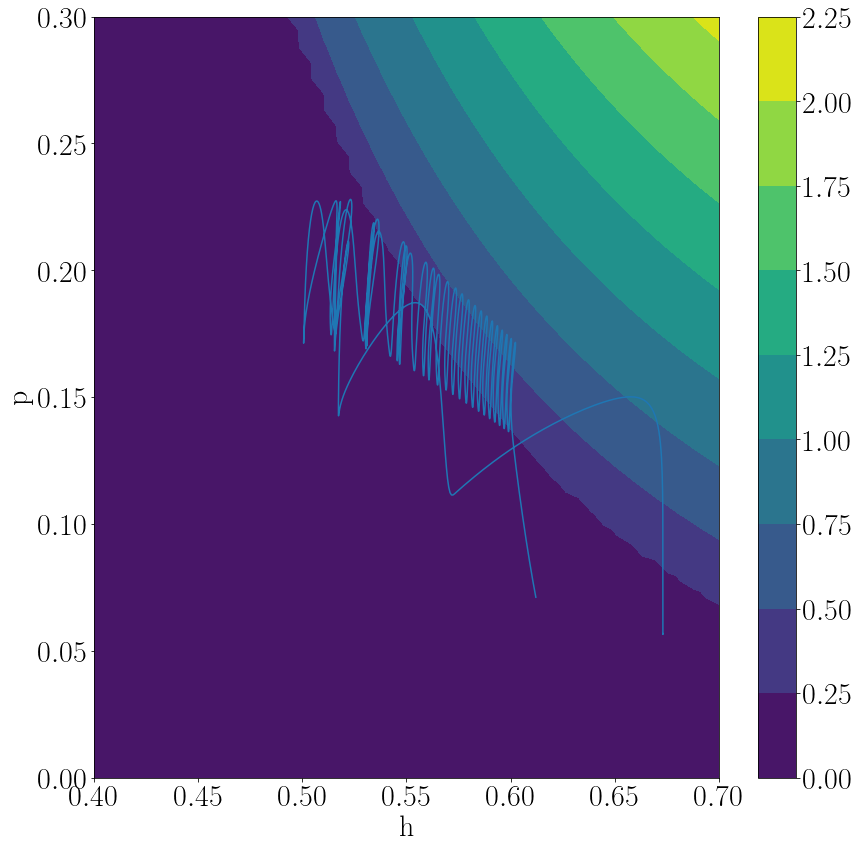

In [27]:
plt.figure(figsize=(14, 14))
mesh_h, mesh_p = np.meshgrid(hs, ps)

plt.contourf(mesh_h, mesh_p, max_cs.reshape(50, 50))

init = inits[220]
init[2] = 0.6 #h
init[3] = 0.1 #p

# test_single_spritz(init, conc=2.4)
# t_idx = np.argmax(cfg.t > 1)
# plt.plot(cfg.h[:t_idx], cfg.p[:t_idx])
# plt.plot(cfg.h[t_idx:], cfg.p[t_idx:])

run_spritz(period=7, conc=1, num=30)
plt.plot(cfg.h, cfg.p)

plt.colorbar()
plt.xlabel('h')
plt.ylabel('p')

### Plotting by c_tot and h

In [44]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([2.44711197e-01, 28, 4.82123581e-01, 0.2,
       1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03]) #manually fix c_tot

var_ranges = get_condition_bounds()
print(var_ranges)
for i in range(8):
    if i not in [1, 2]:
        var_ranges[i] = (avg_nexts[i], avg_nexts[i])

num_trials = 50 * 50
hs = np.linspace(0.4, 0.7, 50)
c_tots = np.linspace(20, 35, 50)

inits = np.zeros((num_trials, 8))
next_vals = np.zeros((num_trials, 8))
max_cs = np.zeros(num_trials)

i = 0
for h in tqdm(hs):
    for c_tot in c_tots:
        init = avg_nexts.copy()
        init[2] = h
        # init[3] = p
        init[1] = c_tot
        
        inits[i] = init

        max_c, next_val = test_single_spritz(init)
        next_vals[i] = next_val
        max_cs[i] = max_c        
        
        i += 1





[(0.0951426886956003, 2.745074839842797), (17.33944611078458, 34.84118401932355), (0.4098683201485111, 0.6731067948382342), (0.05673036161033593, 0.7435682619594675), (0.0, 0.6548959975290456), (0.0, 0.4560533922230593), (0.0, 0.4477948140221652), (0.0, 0.008039091521431327)]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.84s/it]


In [48]:
ts = [i * 8 for i in range(30)]
t_idxs = [np.argmax(cfg.t > t)  for t in ts]


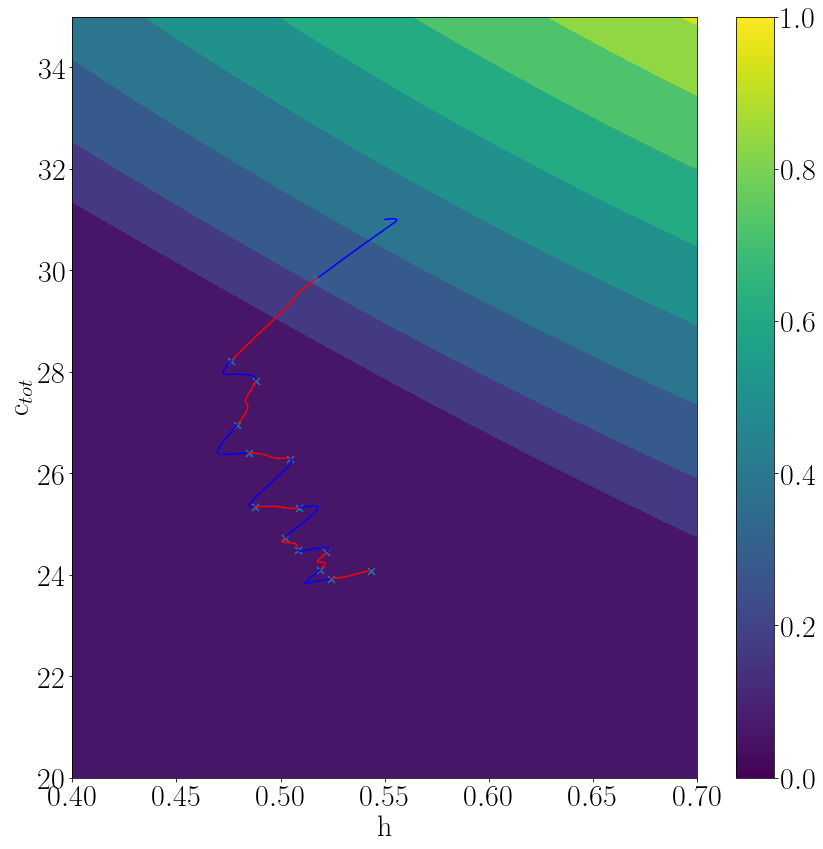

In [86]:
plt.figure(figsize=(14, 14))
mesh_h, mesh_c_tot = np.meshgrid(hs, c_tots)

plt.contourf(mesh_h, mesh_c_tot, max_cs.reshape(50, 50))

init = inits[220]
init[2] = 0.6 #h
init[1] = 26 #p

# test_single_spritz(init, conc=2.4)
# t_idx = np.argmax(cfg.t > 1)
# plt.plot(cfg.h[:t_idx], cfg.p[:t_idx])
# plt.plot(cfg.h[t_idx:], cfg.p[t_idx:])

init = cfg.all_init.copy()
cfg.all_init = init.copy()
cfg.all_init[1] = 31
cfg.all_init[2] = 0.55

period = 7.5
num_spikes = 15
conc = 2

run_spritz(period=period, conc=conc, num=num_spikes)
ts = [i * period for i in range(num_spikes)]
t_idxs = [np.argmax(cfg.t > t)  for t in ts]

colors = ['blue', 'red']
for i in range(len(ts) - 1):
    start = t_idxs[i]
    end = t_idxs[i+1]
    plt.plot(cfg.h[start:end], cfg.c_tot[start:end], c=colors[i%2])
plt.scatter(cfg.h[t_idxs], cfg.c_tot[t_idxs], marker='x', s=50)
plt.colorbar()
plt.xlabel('h')
plt.ylabel('c$_{tot}$')

cfg.all_init = init

Attempt to look further into whether we can make a good model for determining dynamics of spritzes

In [247]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([0.1, 28, 4.82123581e-01, 2.51173827e-01,
       0.05, 0.2, 0.2, 0.01]) #manually fix c_tot

# var_ranges = get_condition_bounds()
var_ranges = [
    (0.1, 0.1),
    (20, 35),
    (0.4, 0.7),
    (0, 0.3),
    (0.05, 0.05),
    (0.2, 0.2),
    (0.2, 0.2),
    (0.01, 0.01)
]

num_trials = 20000

inits = np.zeros((num_trials, 8))
next_vals = np.zeros((num_trials, 8))
max_cs = np.zeros(num_trials)

for i in tqdm(range(num_trials)):
    init = get_random_init(var_ranges)
    inits[i] = init
    
    max_c, next_val = test_single_spritz(init)
    next_vals[i] = next_val
    max_cs[i] = max_c




100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [12:59<00:00, 25.65it/s]


Here note the distributions of the next values after stimulation. The calcium level almost always reverts fully, lending more evidence that we can simply treat it as a fast variable that returns to equilibrium (note this is after 7s, so we have still let it recover for a quite a while)

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


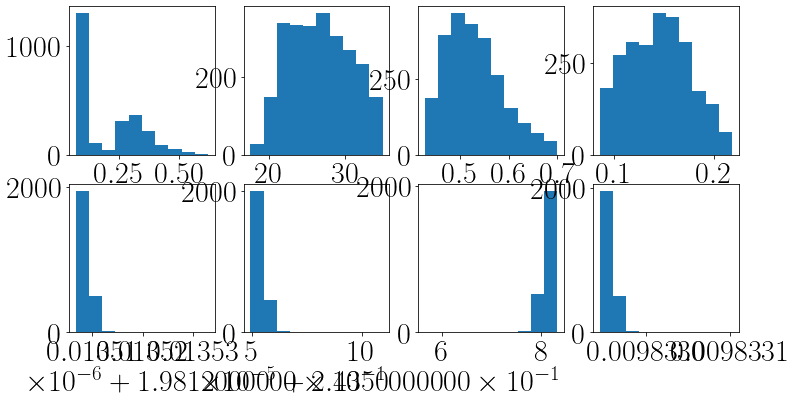

In [301]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    x = i % 4
    y = i // 4
    ax[y, x].hist(next_vals[:, i])
plt.tight_layout()

When attempting to fit a linear regression model, we note that there is a threshold below which calcium does not really respond. We will attempt to separate this off and label them as no responses for modeling purposes

0.7043997186868871
0.9651861070263145


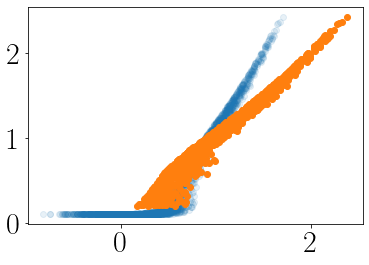

In [323]:
from sklearn.linear_model import LinearRegression, Ridge

# reg = Ridge()
reg = LinearRegression()
reg.fit(inits, max_cs)

pred = reg.predict(inits)

print(r2_score(pred, max_cs))

plt.scatter(pred, max_cs, alpha=0.1)

trunc_inits = inits[max_cs > 0.2]
trunc_cs = max_cs[max_cs > 0.2]
reg = LinearRegression()
reg.fit(trunc_inits, trunc_cs)
pred = reg.predict(trunc_inits)

print(r2_score(pred, trunc_cs))
plt.scatter(pred, trunc_cs)

Also note that we can very easily predict c_total through a linear regression (amount of ER calcium depletion is more or less linearly dependent on initial conditions prior to the spike)

However, h and p are slightly less well predicted, indicating some non-linear interactions.

Linear regression for c_t R^2 0.9709192779833913
Linear regression for h R^2 0.7404448813787856
Linear regression for p R^2 0.8840891047722684


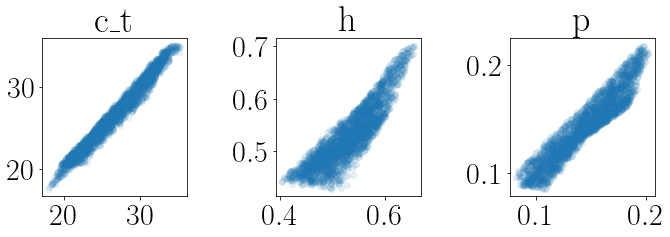

In [300]:
from sklearn.linear_model import LinearRegression, Ridge

# reg = Ridge()
fig, ax = plt.subplots(1, 3, figsize=(10,4))
labels = ['c_t', 'h', 'p']
for i in range(1, 4):
    y = next_vals[:, i]
    reg = LinearRegression()
    reg.fit(inits[:, 1:4], y)
    pred = reg.predict(inits[:, 1:4])
    print(f'Linear regression for {labels[i-1]} R^2 {r2_score(pred, y)}')
    
    ax[i-1].scatter(pred, y, alpha=0.1)
    ax[i-1].set_title(labels[i-1])
plt.tight_layout()

If we split the data into two areas, where there is or is not a response, we get much better regression fits

Linear regression for c_t R^2 0.9966095168590746
Linear regression for h R^2 0.9499529113850421
Linear regression for p R^2 0.952615101603087


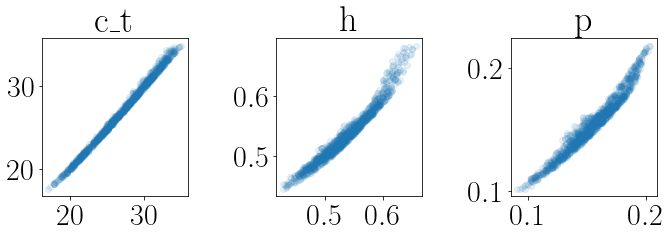

In [324]:
from sklearn.linear_model import LinearRegression, Ridge
trunc_idx = max_cs > 0.2
# reg = Ridge()
fig, ax = plt.subplots(1, 3, figsize=(10,4))
labels = ['c_t', 'h', 'p']
for i in range(1, 4):
    y = next_vals[trunc_idx, i]
    reg = LinearRegression()
    reg.fit(inits[trunc_idx, 1:4], y)
    pred = reg.predict(inits[trunc_idx, 1:4])
    print(f'Linear regression for {labels[i-1]} R^2 {r2_score(pred, y)}')
    
    ax[i-1].scatter(pred, y, alpha=0.1)
    ax[i-1].set_title(labels[i-1])
plt.tight_layout()

Linear regression for c_t R^2 0.999868120116158
Linear regression for h R^2 0.9991715975665942
Linear regression for p R^2 0.9988288746288275


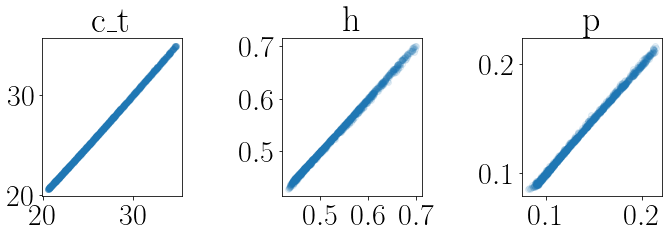

In [325]:
from sklearn.linear_model import LinearRegression, Ridge
trunc_idx = max_cs <= 0.2
# reg = Ridge()
fig, ax = plt.subplots(1, 3, figsize=(10,4))
labels = ['c_t', 'h', 'p']
for i in range(1, 4):
    y = next_vals[trunc_idx, i]
    reg = LinearRegression()
    reg.fit(inits[trunc_idx, 1:4], y)
    pred = reg.predict(inits[trunc_idx, 1:4])
    print(f'Linear regression for {labels[i-1]} R^2 {r2_score(pred, y)}')
    
    ax[i-1].scatter(pred, y, alpha=0.1)
    ax[i-1].set_title(labels[i-1])
plt.tight_layout()

We search for the threshold below which calcium does not respond

Number of responses reaching less than 0.2: 1400


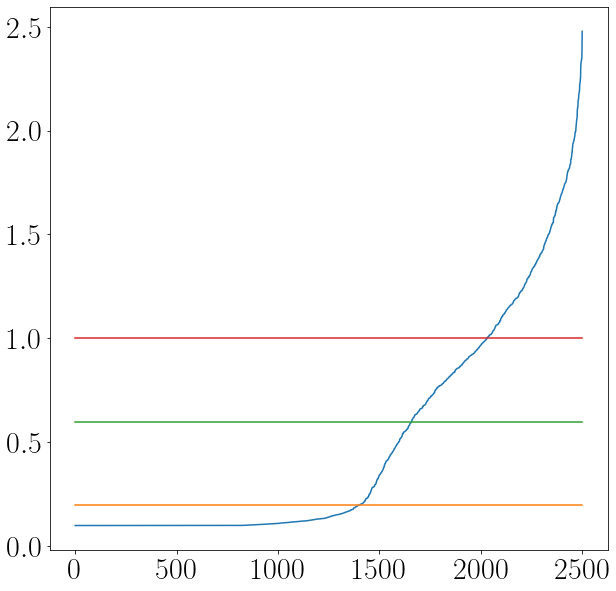

In [140]:
# Look for a threshold
sorted_responses = max_cs.copy()
sorted_responses.sort()
plt.figure(figsize=(10, 10))
plt.plot(np.arange(2500), sorted_responses)
plt.plot([0, 2500], [0.2, 0.2])
plt.plot([0, 2500], [0.6, 0.6])
plt.plot([0, 2500], [1, 1])

print(f'Number of responses reaching less than 0.2: {len(max_cs[max_cs <= 0.2])}')

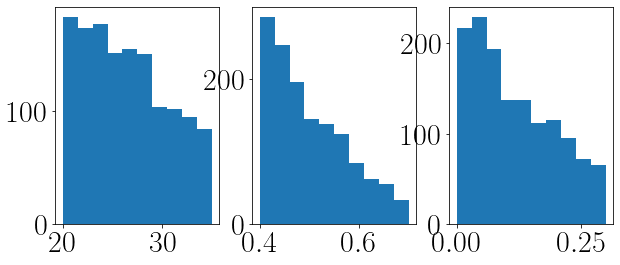

In [305]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
truncated = inits[max_cs <= 0.2][:, 1:4]
for i in range(3):
    ax[i].hist(truncated[:, i])

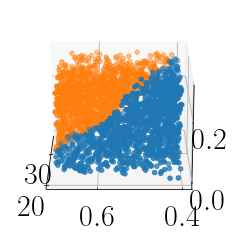

In [335]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(20, 180)

trunc_idx = max_cs <= 0.2
trunc_idx2 = max_cs > 0.2
ax.scatter3D(inits[trunc_idx,1], inits[trunc_idx,2], inits[trunc_idx,3])
ax.scatter3D(inits[trunc_idx2,1], inits[trunc_idx2,2], inits[trunc_idx2,3])

In [344]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()
labels = (max_cs > 0.2) * 1

clf.fit(inits, labels)
pred = clf.predict(inits)

print(f'Accuracy score: {accuracy_score(pred, labels)}')

Accuracy score: 0.956


## Failure to compress data with a nonlinear approximator

Even applying a neural network to the data, if we attempt to compress information into 2 dimensions in the final layer, we still have the same loss of regression capacity as with linear regression methods

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1080.00it/s]


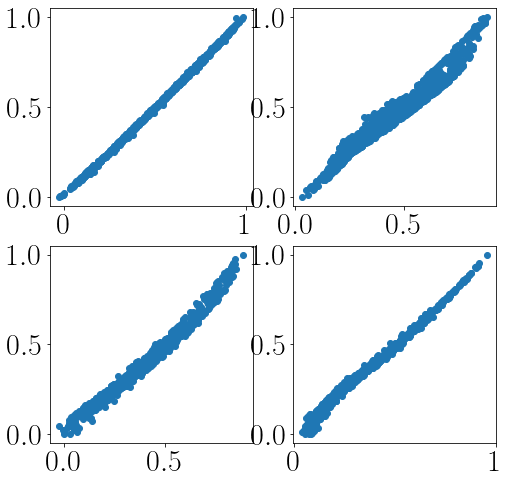

In [87]:
# Attempts to fit a NN to the data did not work

from torch import nn
from torch import optim
import torch
from sklearn.preprocessing import MinMaxScaler

# model = nn.Sequential(nn.Linear(3, 16), nn.ReLU(), nn.Linear(16, 2), nn.Linear(2, 4))
model = nn.Sequential(nn.Linear(3, 8), nn.ReLU(), nn.Linear(8, 4))
# model = nn.Sequential(nn.Linear(3, 2), nn.Linear(2, 4))
norm = MinMaxScaler()

trunc_idx = max_cs <= 0.2
trunc_idx2 = max_cs > 0.3

# x = torch.tensor(inits[trunc_idx2, 1:4], dtype=torch.float)
# x = torch.tensor(norm.fit_transform(x), dtype=torch.float)
# y = torch.tensor(max_cs.reshape(-1, 1), dtype=torch.float)
# y = torch.tensor(next_vals[:, 2].reshape(-1, 1), dtype=torch.float)

y = np.concatenate([next_vals[trunc_idx2, 1:4], max_cs.reshape(-1,1)[trunc_idx2]], axis=1)
# y = np.concatenate([next_vals[:, 1:4], max_cs.reshape(-1,1)[:]], axis=1)

norm.fit(y)
x = inits[trunc_idx2, 1:5]
# x = inits[:, 1:5]
x = torch.tensor(norm.transform(x)[:, :3], dtype=torch.float)

y = torch.tensor(norm.transform(y), dtype=torch.float)
optimizer = optim.Adam(model.parameters(), eps=0.01)
loss_fun = nn.MSELoss()

losses = []
for i in tqdm(range(10000)):
    y_pred = model(x)
    loss = loss_fun(y, y_pred)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i].detach(), y[:, i])

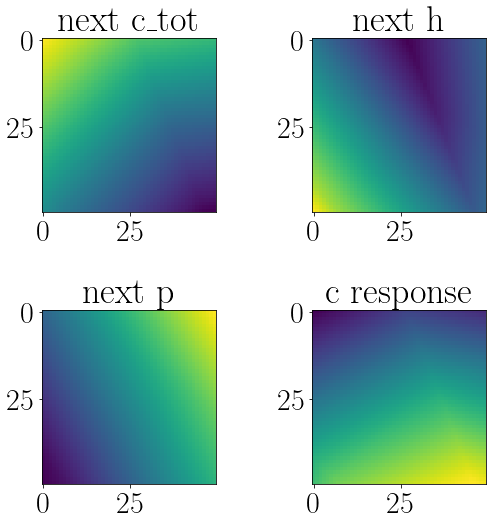

In [136]:
hs = np.linspace(0.4, 0.7, 50)
ps = np.linspace(0, 0.3, 50)
c_tots = np.linspace(20, 35, 50)

x = []
for h in hs:
    for p in ps:
        x.append([5,h,p,0])

x = torch.tensor(norm.transform(x)[:, :3], dtype=torch.float)
y_pred = model(x).detach()

# run_spritz(period=period, conc=conc, num=num_spikes)
# ts = [i * period for i in range(num_spikes)]
# t_idxs = [np.argmax(cfg.t > t)  for t in ts]

# traj = np.array([cfg.c_tot, cfg.h, cfg.p])
# traj = norm.transform(traj.T)
# traj = np.array([traj[:, 0], np.dot(traj[:, 1:], proj)]).T

# colors = ['blue', 'red']

plot_titles = ['next c_tot', 'next h', 'next p', 'c response']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax_x = i // 2
    ax_y = i % 2
    y_plot = y_pred[:, i].reshape(50, 50)
    ax[ax_x, ax_y].imshow(y_plot)
    ax[ax_x, ax_y].set_title(plot_titles[i])
    


    
plt.tight_layout()

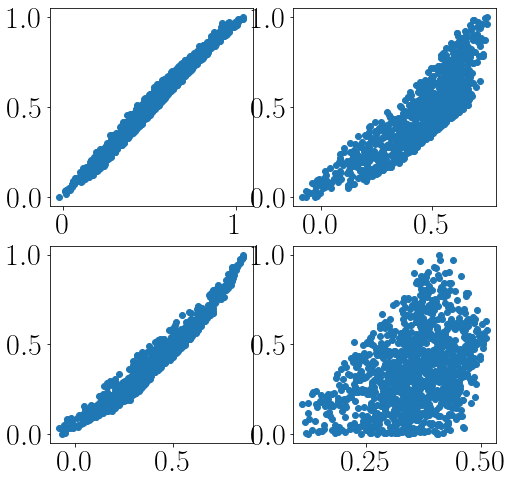

In [529]:
losses = []
for i in range(5000):
    y_pred = model(x)
    loss = loss_fun(y, y_pred)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i].detach(), y[:, i])

In [543]:
r2_score(y_pred.detach()[:, 0], y[:, 0])

0.9995380608924396

In [515]:
projector = model[0]

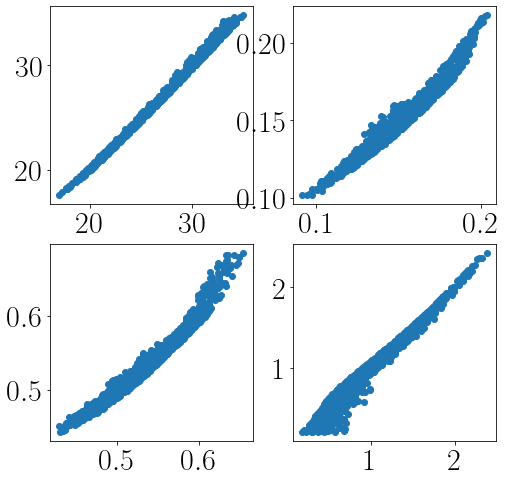

In [380]:
# Attempts to fit a NN to the data did not work

from torch import nn
from torch import optim
import torch

# model = nn.Sequential(nn.Linear(3, 32), nn.Linear(32, 4))
# model = nn.Sequential(nn.Linear(3, 2), nn.Linear(2, 4))
model = LinearRegression()
trunc_idx = max_cs <= 0.2
trunc_idx2 = max_cs > 0.2

x = torch.tensor(inits[trunc_idx2, 1:4], dtype=torch.float)
# y = torch.tensor(max_cs.reshape(-1, 1), dtype=torch.float)
# y = torch.tensor(next_vals[:, 2].reshape(-1, 1), dtype=torch.float)
y = np.concatenate([next_vals[trunc_idx2, 1:4], max_cs.reshape(-1,1)[trunc_idx2]], axis=1)
y = torch.tensor(y, dtype=torch.float)
# optimizer = optim.Adam(model.parameters(), eps=0.01)
# loss_fun = nn.MSELoss()

# losses = []
# for i in range(50000):
#     y_pred = model(x)
#     loss = loss_fun(y, y_pred)
#     losses.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
model.fit(x, y)
y_pred = model.predict(x)


fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])

### Try to fit Regression using some h-p vector

In [582]:
np.array(range(3))

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

array([ True, False, False])

## Splitting into manual classes
We note that if we split the init points into segments of response strengths, we get nicer predictions on the future paths of c_tot, h, p. Then we can simply plot based on a regression rather than worrying about exact values. Notably, for the majority of these classses, the ideal theta for projection vector is pretty constant (around 1.6), with the exception of class 0 where there is no effective response. Here, the algorithm opts to completely ignore h prediction, since it is inherently random (based only on initial condition), so we will keep the theta of ~1.6.

5.458120569873176


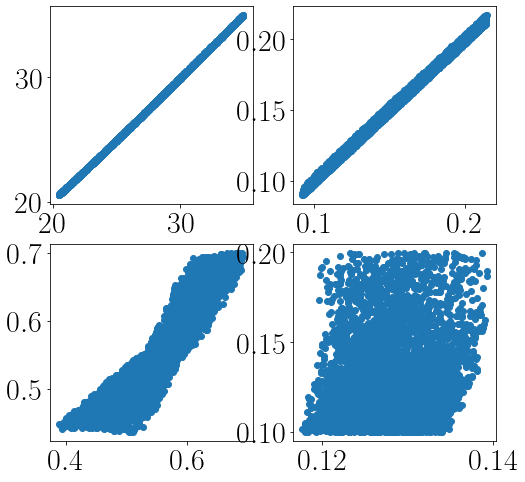

In [256]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import torch

def proj_x(x, proj_cols, proj):
    '''
    Project a vector of the given columns
    '''
    cols = np.array(range(x.shape[1]))
    missing_cols = ~np.isin(cols, proj_cols)
    projected = np.matmul(x[:, proj_cols], proj)
    remaining_x = x[:, missing_cols]
    
    # if projected.dim() == 1:
    projected = projected.reshape(-1, 1)
#     print(remaining_x.shape)
#     print(projected.shape)
    
    x = np.concatenate([x[:, missing_cols], projected], axis=1)
    
    return x


def find_best_projection(x, y, proj_cols):
    thetas = np.linspace(0, 2*np.pi, 100)
    
    r2_scores = []
    mses = []
    for theta in thetas:
        proj = np.array([np.cos(theta), np.sin(theta)])
        
        model = LinearRegression()
        x_proj = proj_x(x, proj_cols, proj)
        model.fit(x_proj, y)
        y_pred = model.predict(x_proj)

        r2_scores.append(r2_score(y_pred, y))
        mses.append(mean_squared_error(y_pred, y))
    
    theta = thetas[np.argmin(mses)]
    proj = np.array([np.cos(theta), np.sin(theta)])
    
    model = LinearRegression()
    x_proj = proj_x(x, proj_cols, proj)
    model.fit(x_proj, y)
    y_pred = model.predict(x_proj)
    
    r2 = r2_score(y_pred, y)
    mse = mean_squared_error(y_pred, y)
    
    return proj, theta, model, x_proj, y_pred, r2_scores, mses
    

norm = MinMaxScaler()
model = LinearRegression()
trunc_idx0 = (max_cs <= 0.1)
trunc_idx1 = (max_cs > 0.1) & (max_cs <= 0.2)
trunc_idx2 = (max_cs > 0.2) & (max_cs <= 0.6)
trunc_idx3 = (max_cs > 0.6) & (max_cs <= 1)
trunc_idx4 = (max_cs > 1) & (max_cs <= 1.5)
trunc_idx5 = (max_cs > 1.5)

trunc_idx = trunc_idx1

thetas = np.linspace(0, 2*np.pi, 100)
x = inits[:, 1:4]
# x = torch.tensor(norm.fit_transform(x), dtype=torch.float)
x = torch.tensor(inits[trunc_idx, 1:4], dtype=torch.float)
y = np.concatenate([next_vals[trunc_idx, 1:4], max_cs.reshape(-1,1)[trunc_idx]], axis=1)
y = torch.tensor(y, dtype=torch.float)

    
#This produces the best R2 score
proj_cols = [0, 1]
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, proj_cols)
print(theta)

fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])

### Multiclass logistic regression

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder


trunc_idx0 = (max_cs <= 0.1)
trunc_idx1 = (max_cs > 0.1) & (max_cs <= 0.2)
trunc_idx2 = (max_cs > 0.2) & (max_cs <= 0.6)
trunc_idx3 = (max_cs > 0.6) & (max_cs <= 1)
trunc_idx4 = (max_cs > 1) & (max_cs <= 1.5)
trunc_idx5 = (max_cs > 1.5)
trunc_idxs = [trunc_idx0, trunc_idx1, trunc_idx2, trunc_idx3, trunc_idx4, trunc_idx5]

theta = 1.7


labels = np.zeros(len(max_cs))
for i, idxs in enumerate(trunc_idxs):
    labels[idxs] = i
labels = labels.reshape(-1, 1)
enc = OneHotEncoder()
# labels = enc.fit_transform(labels)

x_proj = proj_x(inits[:, 1:4], proj_cols, proj)
clf = xgb.XGBClassifier(max_depth=10)

# clf = LogisticRegression(multi_class='ovr')
clf.fit(x_proj, labels)

C:\Users\Andy\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Andy\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [258]:
accuracy_score(clf.predict(x_proj), labels)

0.78805

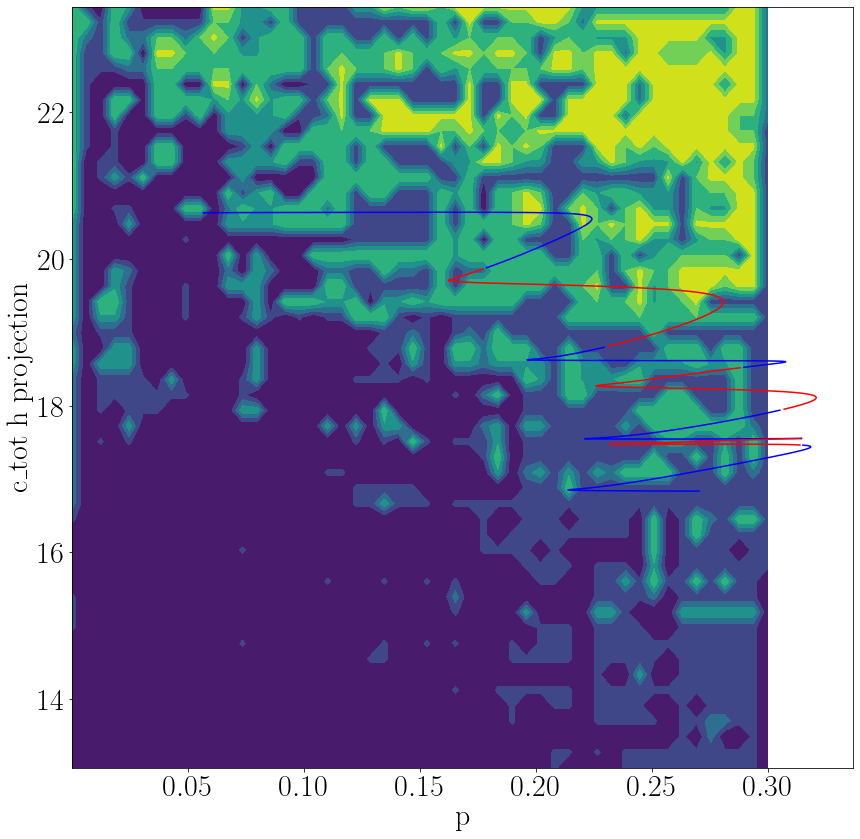

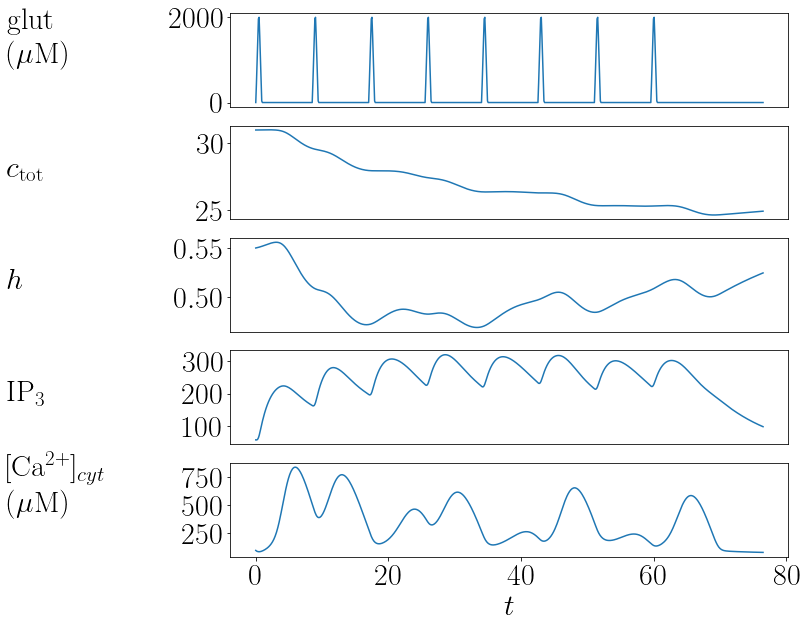

In [259]:
x1 = np.linspace(x_proj[:,0].min(), x_proj[:,0].max(), 50)
x2 = np.linspace(x_proj[:,1].min(), x_proj[:,1].max(), 50)

# mesh_h, mesh_p = np.meshgrid(hs, ps)
# h_p = []
# for h in hs:
#     for p in ps:
#         h_p.append([28, h, p])

mesh1, mesh2 = np.meshgrid(x1, x2)
xpoints = []
for i in x1:
    for j in x2:
        xpoints.append([i, j])
        
# y_pred = clf.predict(h_p)
# plt.contourf(mesh_h, mesh_p, y_pred.reshape(50, 50))

plt.figure(figsize=(14,14))
y_pred = clf.predict(xpoints)
plt.contourf(mesh1, mesh2, y_pred.reshape(50, 50))
plt.xlabel('p')
plt.ylabel('c_tot h projection')



init = cfg.all_init.copy()
cfg.all_init = init.copy()
cfg.all_init[1] = 31
cfg.all_init[2] = 0.55

period = 7.5
num_spikes = 8
conc = 2

run_spritz(period=period, conc=conc, num=num_spikes)
ts = [i * period for i in range(num_spikes)]
t_idxs = [np.argmax(cfg.t > t)  for t in ts]

traj = np.array([cfg.c_tot, cfg.h, cfg.p]).T
# traj = np.array([traj[:, 0], np.dot(traj[:, 1:], proj)]).T
traj = proj_x(traj, proj_cols, proj)

colors = ['blue', 'red']
for i in range(len(ts) - 1):
    start = t_idxs[i]
    end = t_idxs[i+1]
    plt.plot(traj[start:end, 0], traj[start:end, 1], c=colors[i%2])

plt.show()
plot_experiment_plots(['glut', 'c_tot', 'h', 'p', 'c'])

In [239]:
traj

array([[ 0.05676776, -3.86735819],
       [ 0.05668971, -3.86735417],
       [ 0.05658009, -3.86734392],
       ...,
       [ 0.09184379, -2.85084715],
       [ 0.09102903, -2.85133735],
       [ 0.09041403, -2.85171165]])

## Collapse experiments

Test to see if we project two variables (out of c_tot, h, p) down to one dimension, what is the best linear regression we can perform that models the next c_tot, h, p, and max_c response given initial conditions.

Note that depending on which dimensions we reduce, the variables we can predict change, suggesting that certain variables are more important

#### Collapse c_tot and h together
Here it shows that p is actually important for predicting future c_tot and h

This actually looks like the best as far as tracking transition states goes

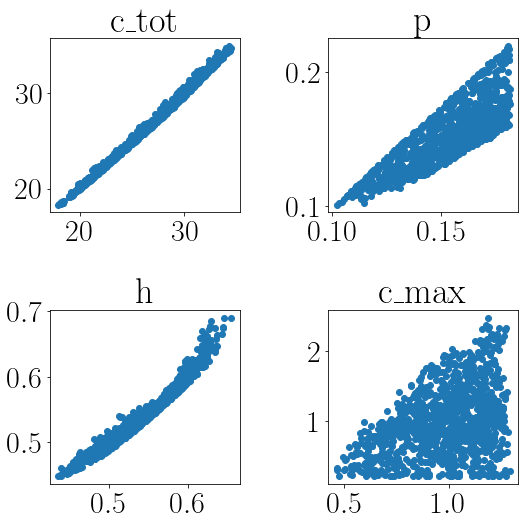

In [143]:
#This produces the best R2 score
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, [0,1])

titles = ['c_{tot}', 'h', 'p', 'c_{max}']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])
    ax[i%2, i//2].set_title(titles[i])
plt.tight_layout()

##### Note about continuing use of the same projection vector

Unforunately, below the spike threshold it is hard to predict h accurately

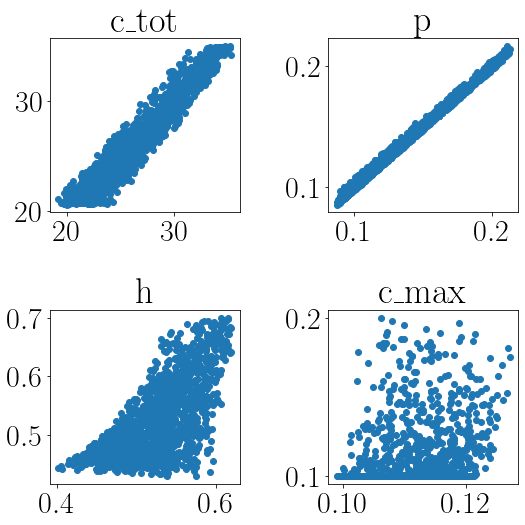

In [708]:
x2 = inits[:, 1:4]
x2 = torch.tensor(norm.fit_transform(x), dtype=torch.float)
x2 = torch.tensor(inits[trunc_idx1, 1:4], dtype=torch.float)
y2 = np.concatenate([next_vals[trunc_idx1, 1:4], max_cs.reshape(-1, 1)[trunc_idx1]], axis=1)
y2 = torch.tensor(y2, dtype=torch.float)

proj_cols = [0,1]
model = LinearRegression()
x_proj = proj_x(x2, proj_cols, proj)
model.fit(x_proj, y2)
y_pred = model.predict(x_proj)

titles = ['c_{tot}', 'h', 'p', 'c_{max}']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y2[:, i])
    ax[i%2, i//2].set_title(titles[i])
plt.tight_layout()

#### Collapsing c_tot and p together

On the flip side, h is useful for tracking the future p vals

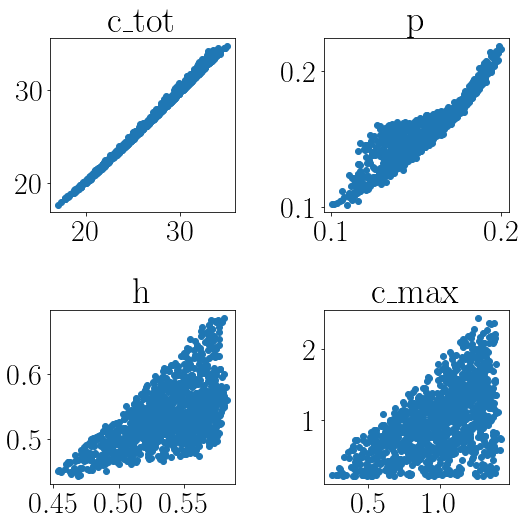

In [652]:
#This produces the best R2 score
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, [0,2])

titles = ['c_{tot}', 'h', 'p', 'c_{max}']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])
    ax[i%2, i//2].set_title(titles[i])
plt.tight_layout()

#### Collapsing h and p together

Finally, if we collapse h-p together, we have a good predictor for the actual response. This is in line with observations overall that c_tot is a large contributor to the spike response level, especially for higher spike ranges.

It is also useful to note that c_tot depletes in an orderly fashion, so if c_tot is important for predicting response levels we might just be able to say that response levels are similar to a graph fixed in c_tot that decrease over time

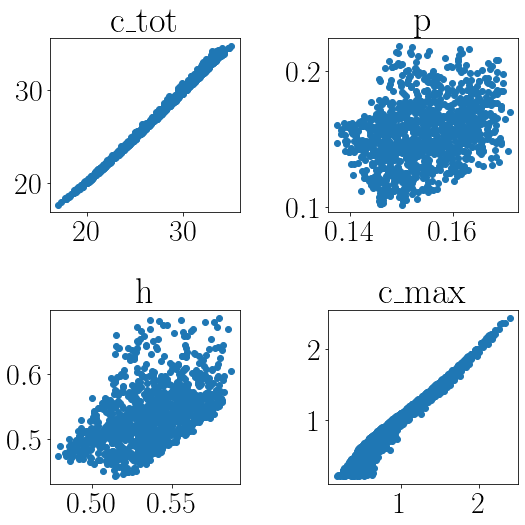

In [653]:
#This produces the best R2 score
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, [1,2])

titles = ['c_{tot}', 'h', 'p', 'c_{max}']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])
    ax[i%2, i//2].set_title(titles[i])
plt.tight_layout()

## Without projecting 2 dimensions, if we just use h and p to predict

We get worse predictions that the projection method

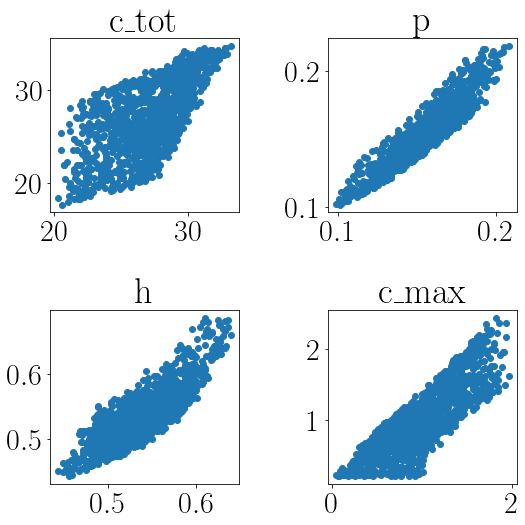

In [655]:
x_proj = x[:, [1,2]]
model = LinearRegression()
model.fit(x_proj, y)
y_pred = model.predict(x_proj)

titles = ['c_{tot}', 'h', 'p', 'c_{max}']
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])
    ax[i%2, i//2].set_title(titles[i])
plt.tight_layout()

In [567]:
# Attempts to fit a NN to the data did not work
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

norm = MinMaxScaler()
model = LinearRegression()
trunc_idx = max_cs <= 0.2
trunc_idx2 = max_cs > 0.2

thetas = np.linspace(0, 2*np.pi, 100)
x = torch.tensor(inits[trunc_idx2, 1:4], dtype=torch.float)
x = norm.fit_transform(x)
y = np.concatenate([next_vals[trunc_idx2, 1:4], max_cs.reshape(-1,1)[trunc_idx2]], axis=1)
y = torch.tensor(y, dtype=torch.float)

r2_scores = []
mses = []
proj_cols = [1,2]
for theta in thetas:
    #project the h_p vector using theta
    proj = np.array([np.cos(theta), np.sin(theta)])
    h_p_proj = np.dot(x[:, proj_cols], proj)
    x_proj = np.concatenate([x[:, 0].reshape(-1, 1), h_p_proj.reshape(-1,1)], axis=1)

    model.fit(x_proj, y)
    y_pred = model.predict(x_proj)
    
    r2_scores.append(r2_score(y_pred, y))
    mses.append(mean_squared_error(y_pred, y))




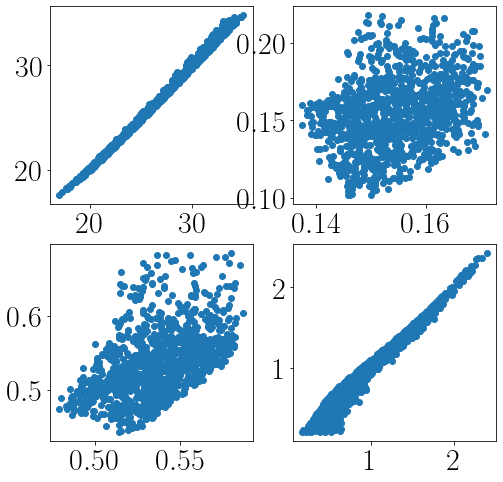

In [572]:
# theta = thetas[np.array(mses).argmin()]
# proj = np.array([np.cos(theta), np.sin(theta)])
# h_p_proj = np.dot(x[:, 1:3], proj)
# x_proj = np.concatenate([x[:, 0].reshape(-1, 1), h_p_proj.reshape(-1,1)], axis=1)
# reg = LinearRegression()
# reg.fit(x_proj, y)


y_pred = reg.predict(x_proj)


# x = torch.tensor(x, dtype=torch.float)
# x_proj = projector(x).detach()
# reg = LinearRegression()
# reg.fit(x_proj, y)
# y_pred = reg.predict(x_proj)


fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])

# Plotting using our c_tot, h collapsed projections


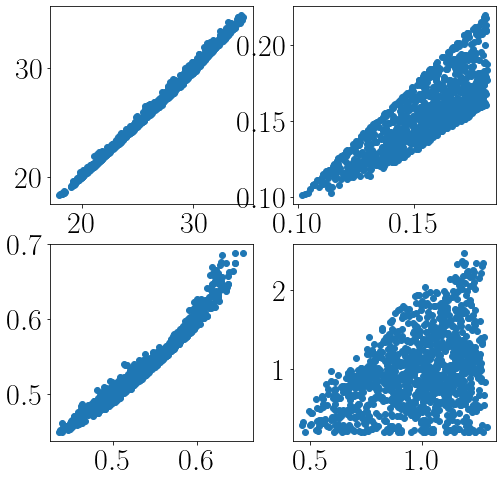

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import torch
from sklearn.metrics import r2_score, mean_squared_error

def proj_x(x, proj_cols, proj):
    '''
    Project a vector of the given columns
    '''
    cols = np.array(range(x.shape[1]))
    missing_cols = ~np.isin(cols, proj_cols)
    projected = np.matmul(x[:, proj_cols], proj)
    remaining_x = x[:, missing_cols]
    
    if projected.dim() == 1:
        projected = projected.reshape(-1, 1)
#     print(remaining_x.shape)
#     print(projected.shape)
    
    x = np.concatenate([x[:, missing_cols], projected], axis=1)
    
    return x


def find_best_projection(x, y, proj_cols):
    thetas = np.linspace(0, 2*np.pi, 100)
    
    r2_scores = []
    mses = []
    for theta in thetas:
        proj = np.array([np.cos(theta), np.sin(theta)])
        
        model = LinearRegression()
        x_proj = proj_x(x, proj_cols, proj)
        model.fit(x_proj, y)
        y_pred = model.predict(x_proj)

        r2_scores.append(r2_score(y_pred, y))
        mses.append(mean_squared_error(y_pred, y))
    
    theta = thetas[np.argmin(mses)]
    proj = np.array([np.cos(theta), np.sin(theta)])
    
    model = LinearRegression()
    x_proj = proj_x(x, proj_cols, proj)
    model.fit(x_proj, y)
    y_pred = model.predict(x_proj)
    
    r2 = r2_score(y_pred, y)
    mse = mean_squared_error(y_pred, y)
    
    return proj, theta, model, x_proj, y_pred, r2_scores, mses
    

norm = MinMaxScaler()
model = LinearRegression()
trunc_idx1 = max_cs <= 0.2
trunc_idx2 = max_cs > 0.2

thetas = np.linspace(0, 2*np.pi, 100)
x = inits[:, 1:4]
x = torch.tensor(norm.fit_transform(x), dtype=torch.float)
x = torch.tensor(inits[trunc_idx2, 1:4], dtype=torch.float)
y = np.concatenate([next_vals[trunc_idx2, 1:4], max_cs.reshape(-1,1)[trunc_idx2]], axis=1)
y = torch.tensor(y, dtype=torch.float)

    
#This produces the best R2 score
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, [0,1])

fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i in range(4):
    ax[i%2, i//2].scatter(y_pred[:, i], y[:, i])

In [ ]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([0.1, 28, 4.82123581e-01, 2.51173827e-01,
       0.05, 0.2, 0.2, 0.01]) #manually fix c_tot

# var_ranges = get_condition_bounds()
var_ranges = [
    (0.1, 0.1),
    (20, 35),
    (0.4, 0.7),
    (0, 0.3),
    (0.05, 0.05),
    (0.2, 0.2),
    (0.2, 0.2),
    (0.01, 0.01)
]

num_trials = 50 * 50

inits = np.zeros((num_trials, 8))
next_vals = np.zeros((num_trials, 8))
max_cs = np.zeros(num_trials)

for i in tqdm(range(num_trials)):
    init = get_random_init(var_ranges)
    inits[i] = init
    
    max_c, next_val = test_single_spritz(init)
    next_vals[i] = next_val
    max_cs[i] = max_c




In [81]:
norm = MinMaxScaler().fit(inits[:, 1:4])

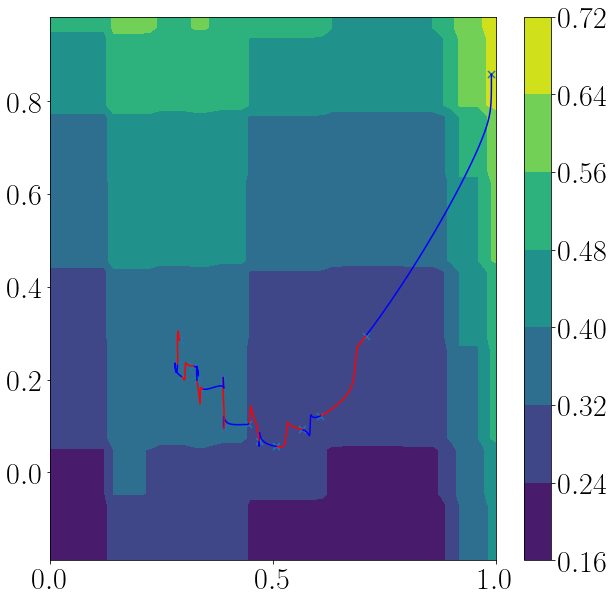

In [84]:
from spritz_diagram import *
import xgboost as xgb

proj_cols = [0, 1]
proj, theta, model, x_proj, y_pred, r2, mse = find_best_projection(x, y, proj_cols)

reg = model
xgb_model = xgb.XGBRegressor(max_depth=1)

xgb_model.fit(x_proj, y[:, 2])

hs = np.linspace(0.4, 0.7, 50)
ps = np.linspace(0, 0.3, 50)
c_tots = np.linspace(20, 35, 50)

c_tots, hs, ps = norm.transform(np.concatenate([
    c_tots.reshape(-1,1), hs.reshape(-1,1), ps.reshape(-1,1)], axis=1)).T

h_p_points = []
for h in hs:
    for p in ps:
        h_p_points.append([h, p])
        
h_p_projection = np.dot(np.array(h_p_points), proj)
projecteds = np.linspace(np.min(h_p_projection), np.max(h_p_projection),
                         50)

combined_points = []
for c_tot in c_tots:
    for project in projecteds:
        combined_points.append([c_tot, project])

c_preds = xgb_model.predict(np.array(combined_points))

mesh_ctot, mesh_projecteds = np.meshgrid(c_tots, projecteds)

plt.figure(figsize=(10,10))
plt.contourf(mesh_ctot, mesh_projecteds, c_preds.reshape(50,50))
plt.colorbar()



period = 7.5
num_spikes = 15
conc = 2

run_spritz(period=period, conc=conc, num=num_spikes)
ts = [i * period for i in range(num_spikes)]
t_idxs = [np.argmax(cfg.t > t)  for t in ts]

traj = np.array([cfg.c_tot, cfg.h, cfg.p])
traj = norm.transform(traj.T)
traj = np.array([traj[:, 0], np.dot(traj[:, 1:], proj)]).T

colors = ['blue', 'red']
for i in range(len(ts) - 1):
    start = t_idxs[i]
    end = t_idxs[i+1]
    plt.plot(traj[start:end, 0], traj[start:end, 1], c=colors[i%2])
plt.scatter(traj[t_idxs, 0], traj[t_idxs, 1], marker='x', s=50)


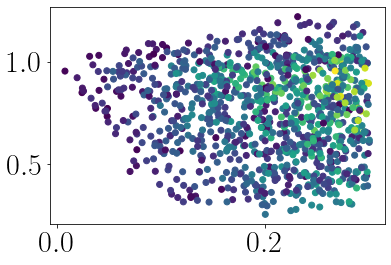

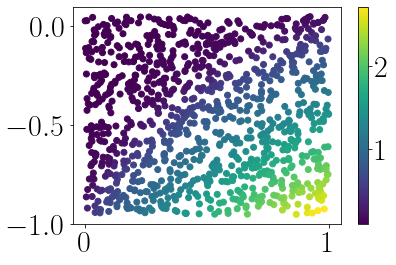

0.2623208436002653


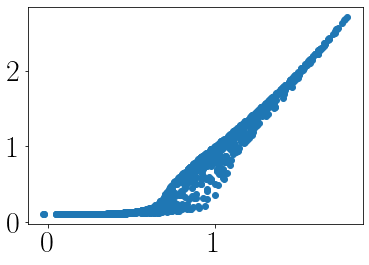

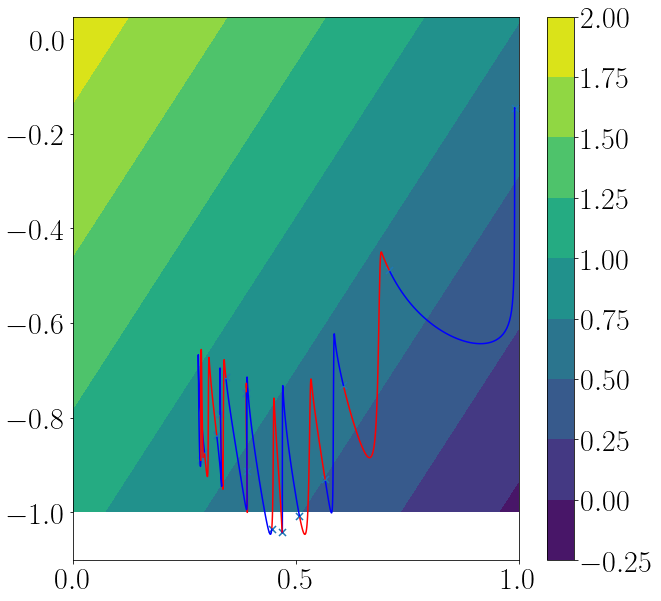

In [75]:
from sklearn.kernel_ridge import KernelRidge

# idx2 = y[:,3]>0.3

# plt.scatter(x_proj.T[0, idx2], x_proj.T[1, idx2], c=y[idx2,3])
# plt.show()

# ker = KernelRidge()
# ker.fit(x_proj[idx2], y[idx2,3])

# y_pred = ker.predict(x_proj[idx2])
# print(r2_score(y_pred, y[idx2, 3]))
# plt.scatter(y_pred, y[idx2, 3])




plt.scatter(proj_x2.T[0], proj_x2.T[1], c=max_cs2)
plt.colorbar()
plt.show()

ker = KernelRidge()
ker.fit(proj_x2, max_cs2)

y_pred = ker.predict(proj_x2)
print(r2_score(y_pred, max_cs2))
plt.scatter(y_pred, max_cs2)
plt.show()

c_preds = ker.predict(np.array(combined_points))

mesh_ctot, mesh_projecteds = np.meshgrid(c_tots, projecteds)

plt.figure(figsize=(10,10))
plt.contourf(mesh_ctot, mesh_projecteds, c_preds.reshape(50,50))
plt.colorbar()

run_spritz(period=period, conc=conc, num=num_spikes)
ts = [i * period for i in range(num_spikes)]
t_idxs = [np.argmax(cfg.t > t)  for t in ts]

traj = np.array([cfg.c_tot, cfg.h, cfg.p])
traj = norm.transform(traj.T)
traj = np.array([traj[:, 0], np.dot(traj[:, 1:], proj)]).T

colors = ['blue', 'red']
for i in range(len(ts) - 1):
    start = t_idxs[i]
    end = t_idxs[i+1]
    plt.plot(traj[start:end, 0], traj[start:end, 1], c=colors[i%2])
plt.scatter(traj[t_idxs, 0], traj[t_idxs, 1], marker='x', s=50)


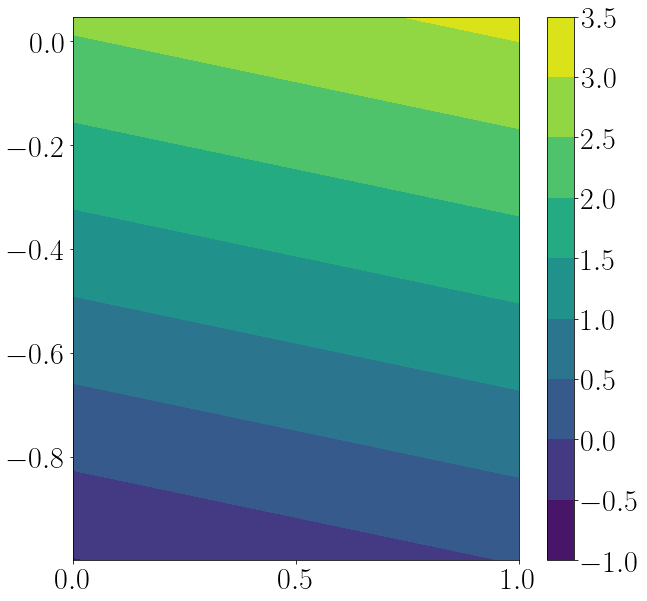

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.58it/s]


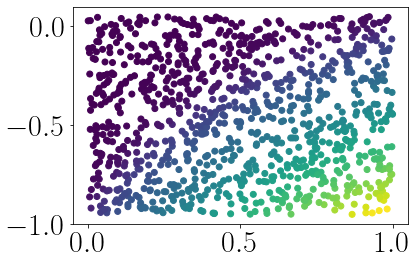

In [72]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([0.1, 28, 4.82123581e-01, 2.51173827e-01,
       0.05, 0.2, 0.2, 0.01]) #manually fix c_tot

# var_ranges = get_condition_bounds()
var_ranges = [
    (0.1, 0.1),
    (35, 35),
    (0.4, 0.7),
    (0, 0.3),
    (0.05, 0.05),
    (0.2, 0.2),
    (0.2, 0.2),
    (0.01, 0.01)
]

num_trials = 1000

inits2 = np.zeros((num_trials, 8))
next_vals2 = np.zeros((num_trials, 8))
max_cs2 = np.zeros(num_trials)

for i in tqdm(range(num_trials)):
    init = get_random_init(var_ranges)
    inits2[i] = init
    
    max_c, next_val = test_single_spritz(init)
    next_vals2[i] = next_val
    max_cs2[i] = max_c


x2 = torch.tensor(norm.transform(inits2[:, 1:4]))
proj_x2 = proj_x(x2, proj_cols, proj)

plt.scatter(proj_x2.T[0], proj_x2.T[1], c=max_cs2)

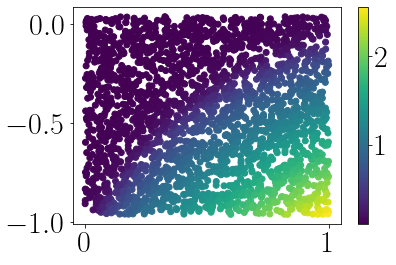

In [71]:
plt.scatter(proj_x2.T[0], proj_x2.T[1], c=max_cs2)
plt.colorbar()

In [ ]:
from spritz_diagram import *
import xgboost as xgb

# next_vals.mean(axis=0)
# use average next values collected from earlier as fixed values for spritz diagram
# avg_nexts = np.array([2.44711197e-01, 2.08128485e+01, 4.82123581e-01, 2.51173827e-01,
#        1.52448082e-02, 3.57727944e-01, 3.25095088e-01, 6.88028505e-03])
avg_nexts = np.array([0.1, 28, 4.82123581e-01, 2.51173827e-01,
       0.05, 0.2, 0.2, 0.01]) #manually fix c_tot

# var_ranges = get_condition_bounds()
var_ranges = [
    (0.1, 0.1),
    (32, 32),
    (0.4, 0.7),
    (0, 0.3),
    (0.05, 0.05),
    (0.2, 0.2),
    (0.2, 0.2),
    (0.01, 0.01)
]

num_trials = 50 * 50

inits2 = np.zeros((num_trials, 8))
next_vals2 = np.zeros((num_trials, 8))
max_cs2 = np.zeros(num_trials)

for i in tqdm(range(num_trials)):
    init = get_random_init(var_ranges)
    inits2[i] = init
    
    max_c, next_val = test_single_spritz(init)
    next_vals2[i] = next_val
    max_cs2[i] = max_c


x2 = torch.tensor(norm.transform(inits2[:, 1:4]))
proj_x2 = proj_x(x2, proj_cols, proj)

plt.scatter(proj_x2.T[0], proj_x2.T[1], c=max_cs2)

  1%|▋                                                                               | 22/2500 [00:00<01:32, 26.93it/s]

In [555]:
h_p_points = []
c_tot = 28
for h in hs:
    for p in ps:
        h_p_points.append([h, p])
        
def transform_and_predict(model, norm, h_p_points, c_tot):
    '''
    pass a 2 column matrix of h_p points with fixed c_tot to predict using model, 
    this function will construct a 4 dimension matrix for use with the norm,
    since the normalizer is fitted inlcuding c_max from y
    '''
    h_p_points = np.array(h_p_points)
    h_p_points = np.concatenate([np.full((len(h_p_points),1), c_tot), h_p_points], axis=1)
    h_p_points = np.concatenate([h_p_points, np.zeros((len(h_p_points),1))], axis=1)
    x = torch.tensor(norm.transform(h_p_points), dtype=torch.float)
    
    y_pred = model(x[:, :3]).detach()
    y_pred = norm.inverse_transform(y_pred)
    
    return y_pred
    
y_pred = transform_and_predict(model, norm, h_p_points, c_tot)